# **Predicting Charged-Off Loans with LendingClub Data**

# Table of Contents
1. [Introduction](#intro)
2. [Data](#importdata)
3. [Target Variable](#targetvariable)
4. [Feature Selection I: EDA](#featureselection)  
    4.1 [Drop features missing 50% of the data](#missing_data)  
    4.2 [Remove "cheat" data](#cheat_data)  
    4.3 [Inspect the remaining features one by one](#inspect)  
5. [Feature Section II: Statistical Overview](#corr)   
    5.1 [Convert target variable to 0/1 indicator](#converttarget)   
    5.2 [Hypothesis testing on the two distributions of each feature](#kstest)   
    5.3 [Pearson correlation & Heatmap](#pearson)   
6. [Feature Engineering](#featureeng)  
    6.1 [One-Hot Encoding](#dummies)  
    6.2 [Train/Test data split](#split)  
    6.3 [Imputing missing values](#imputing)  
    6.4 [Feature Scaling](#scaling)  
    6.5 [PCA visualization of the train data](#pca)   
    6.6 [Linear dependence of the Charged-Off loans](#pearson2)
7. [Modeling](#modeling)  
    7.1 [Logistic Regression with SGD](#logreg)  
    7.2 [Random Forest](#rf)   
    7.3 [KNN](#knn)  
    7.4 [Model Evaluation with ROC & Confusion Matrix](#evaluate) 
8. [Conclusion](#conclusion)

Additionally: 
[MyGitHub](https://github.com/abbasmalekpour)
Abbas Malekpour

In [1]:
# Import packages & libraries
import os
import pandas as pd
from pandas import Series, DataFrame

# import pandas_profiling

pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
    learning_curve,
    cross_validate,
)
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    roc_auc_score,
    accuracy_score,
    roc_curve,
)
from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# from sklearn import cross_validation
from sklearn import metrics

"""
from sklearn import metrics
from sklearn import linear_model

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import preprocessing
"""

# ignore Deprecation Warning
import warnings

# warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning)
warnings.filterwarnings("ignore")

# plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option("display.max_columns", None)  # Display any number of columns

/Users/malekpoa/opt/anaconda3/envs/env1/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Introduction
<a id="intro"></a>
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off) and interpret the results to find the factors which affect the result. Such a predictive model could help LendingClub investors make better-informed investment decisions.

We want to develop a model that is **accurate** and **interpretable**.

This problem is a binary classification as I have only two classes to predict.

Finally the best model will be used to predict and check data for year 2016 is Charged_off or not!

## 2. Data
<a id="importdata"></a>

In this project, I will work with the publicly available Lending Club data on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). 
The dataset is 1.8+ GB of size, including 2.2 millions of loans from 2007 to 2018Q, each of which has 152 associated features. 

In [2]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv")
# df = df.sample(frac=.3)
# loan = df.copy()
df.shape

(226070, 152)

In [3]:
df.drop("url", axis=1, inplace=True)
# df = pd.read_csv('../input/accepted_2017.csv.gz',compression='gzip',low_memory=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226070 entries, 0 to 226069
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(113), int64(1), object(37)
memory usage: 260.4+ MB


In [5]:
df.iloc[[0, -1]]

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
0          2236778  91435307        NaN    10000.0      10000.0   
226069     2225582  92350632        NaN    10000.0      10000.0   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
0               10000.0   36 months     11.39       329.24     B        B3   
226069          10000.0   36 months      6.99       308.73     A        A2   

                                emp_title emp_length home_ownership  \
0                         General Manager  10+ years       MORTGAGE   
226069  Registered nurse-house supervisor    2 years       MORTGAGE   

        annual_inc verification_status   issue_d loan_status pymnt_plan desc  \
0          53000.0            Verified  Oct-2016     Current          n  NaN   
226069     60000.0        Not Verified  Nov-2016     Current          n  NaN   

                   purpose               title zip_code addr_state    dti  \
0       debt_consolidation  Debt consolidation    923xx         CA  27.18   
226069  debt_consolidation  Debt consolidation    685xx         NE   7.00   

        delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0               0.0         Sep-1979           660.0            664.0   
226069          0.0         Apr-2004           690.0            694.0   

        inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
0                  0.0                    45.0                     NaN   
226069             1.0                     NaN                    32.0   

        open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0           10.0      0.0     6283.0        73.1       29.0   
226069      13.0      1.0     9312.0        21.0       37.0   

       initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
0                        w    2525.53        2525.53      9233.17   
226069                   w    2406.16        2406.16      8640.56   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0               9233.17          7474.47        1758.70                 0.0   
226069          8640.56          7593.84        1046.72                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
0              0.0                      0.0     Mar-2019           329.24   
226069         0.0                      0.0     Mar-2019           308.73   

       next_pymnt_d last_credit_pull_d  last_fico_range_high  \
0          Apr-2019           Mar-2019                 699.0   
226069     Apr-2019           Mar-2019                 719.0   

        last_fico_range_low  collections_12_mths_ex_med  \
0                     695.0                         0.0   
226069                715.0                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
0                              45.0          1.0        Joint App   
226069                          NaN          1.0       Individual   

        annual_inc_joint  dti_joint verification_status_joint  acc_now_delinq  \
0               131000.0       12.1              Not Verified             0.0   
226069               NaN        NaN                       NaN             0.0   

        tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  \
0             5341.0     304372.0          0.0          3.0          0.0   
226069         107.0     109495.0          3.0          1.0          0.0   

        open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  \
0               1.0                14.0       29328.0     70.0          1.0   
226069          0.0                62.0        2743.0     22.0          4.0   

        open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  \
0               2.0      1438.0      71.0            8600.0     0.0   
226069          5.0      4699.0      21.0           44400.0     0.0   

        total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal 

The dataset has numerical, categorical and missing values. Because there are so many features (150+), i will start the data engineering with dropping unnecessary features and then deal with the remaining features more in detail. 

## 3. Target Variable
<a id="targetvariable"></a>

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [6]:
df["loan_status"].value_counts()

Fully Paid                                             107874
Current                                                 87886
Charged Off                                             26526
Late (31-120 days)                                       2243
In Grace Period                                           849
Late (16-30 days)                                         440
Does not meet the credit policy. Status:Fully Paid        174
Does not meet the credit policy. Status:Charged Off        71
Default                                                     5
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. 
We will only keep the rows with loan_status being "fully paid" or "charged off". 

In [7]:
df = df.loc[df["loan_status"].isin(["Fully Paid", "Charged Off"])]

In [8]:
df["loan_status"].value_counts(normalize=False, dropna=False)

Fully Paid     107874
Charged Off     26526
Name: loan_status, dtype: int64

In [9]:
df["loan_status"].value_counts(normalize=True, dropna=False)

Fully Paid     0.802634
Charged Off    0.197366
Name: loan_status, dtype: float64

About 80% (~647k) of the loans have been fully paid, and 21% (168k) have been charged off. Unbalanced data. I will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

## 4. Feature Selection
<a id="featureselection"></a>

The raw data has 150 features, but not all of them are useful. 

I will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d"). 

I will also address the following:
- convert strings to numerical values
- drop superfluous attributes
- highly correlated predictors

### 4.1 Drop features missing too much data
<a id="missing_data"></a>

In [10]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values", 2: "type"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [11]:
missing_values_table(df)

Your selected dataframe has 151 columns.
There are 104 columns that have missing values.


Missing Values  % of Total Values  \
member_id                                           134400              100.0   
next_pymnt_d                                        134400              100.0   
orig_projected_additional_accrued_interest          134005               99.7   
hardship_dpd                                        133818               99.6   
hardship_type                                       133818               99.6   
hardship_reason                                     133818               99.6   
hardship_status                                     133818               99.6   
deferral_term                                       133818               99.6   
hardship_amount                                     133818               99.6   
hardship_start_date                                 133818               99.6   
payment_plan_start_date                             133818               99.6   
hardship_length                                     133818               99.6   
hardship_end_date                                   133818               99.6   
hardship_loan_status                                133818               99.6   
hardship_last_payment_amount                        133818               99.6   
hardship_payoff_balance_amount                      133818               99.6   
sec_app_mths_since_last_major_derog                 133716               99.5   
sec_app_revol_util                                  132488               98.6   
sec_app_chargeoff_within_12_mths                    132458               98.6   
revol_bal_joint                                     132458               98.6   
sec_app_fico_range_high                             132458               98.6   
sec_app_earliest_cr_line                            132458               98.6   
sec_app_inq_last_6mths                              132458               98.6   
sec_app_mort_acc                                    132458               98.6   
sec_app_open_acc                                    132458               98.6   
sec_app_open_act_il                                 132458               98.6   
sec_app_num_rev_accts                               132458               98.6   
sec_app_fico_range_low                              132458               98.6   
sec_app_collections_12_mths_ex_med                  132458               98.6   
verification_status_joint                           131731               98.0   
annual_inc_joint                                    131702               98.0   
dti_joint                                           131702               98.0   
settlement_percentage                               131049               97.5   
settlement_amount                                   131049               97.5   
settlement_date                                     131049               97.5   
settlement_status                                   131049               97.5   
debt_settlement_flag_date                           131049               97.5   
settlement_term                                     131049               97.5   
desc                                                122107               90.9   
mths_since_last_record                              111573               83.0   
mths_since_recent_bc_dlq                            102166               76.0   
mths_since_last_major_derog                          98917               73.6   
mths_since_recent_revol_delinq                       89080               66.3   
il_util                                              88167               65.6   
mths_since_rcnt_il                                   82223               61.2   
all_util                                             80877               60.2   
open_acc_6m                                          80872               60.2   
inq_last_12m                                         80872               60.2   
total_cu_tl                                          80872               60

From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). I chose 50% as the cutoff.

In [12]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.50].index)

In [13]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [14]:
len(drop_list)

58

In [15]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [16]:
drop_cols(drop_list)

In [17]:
df.shape

(134400, 93)

### 4.2 Remove "cheat" data
<a id="cheat_data"></a>

The goal of this assignment is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, I would like to remove the features that were unavailable before lending a loan.  

In [18]:
print(sorted(df.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

After checking the definition of these features, I will drop the ones that would have not been available before a load was lend. 

In [19]:
drop_list = [
    "acc_now_delinq",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "bc_util",
    "chargeoff_within_12_mths",
    "collection_recovery_fee",
    "collections_12_mths_ex_med",
    "debt_settlement_flag",
    "delinq_2yrs",
    "delinq_amnt",
    "disbursement_method",
    "funded_amnt",
    "funded_amnt_inv",
    "hardship_flag",
    "inq_last_6mths",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "out_prncp",
    "out_prncp_inv",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "pymnt_plan",
    "recoveries",
    "tax_liens",
    "tot_coll_amt",
    "tot_cur_bal",
    "tot_hi_cred_lim",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_int",
    "total_rec_late_fee",
    "total_rec_prncp",
    "total_rev_hi_lim",
]

In [20]:
drop_cols(drop_list)

In [21]:
print(sorted(df.columns))

['Unnamed: 0', 'addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


In [22]:
len(df.columns)

35

### 4.3 Inspect the remaining features one by one
<a id="inspect"></a>

Now we are left with reasonable number of features (35), I will screen each feature and decide if a feature should be dropped. 

The tasks involved are:
- Visualization with count distributions, bar plot & [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) plot with faceting on the loan status
- Drop useless features (e.g., "id")
- Cleaning & Formatting (e.g., ["emp_length"](#emp_length), ["earliest_cr_line"](#earliest_cr_line))
- Transformation of features (e.g., log transformation of ["annual_inc"](#annual_inc), average of ["fico_score"](#fico))
- Pick the most relevant features in the data (e.g., "sub_grade" vs "grade", "zip_code" vs "addr_state")

In [23]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 3))
    # plot1: counts distribution of the variable

    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(
            df[col_name],
            order=sorted(df[col_name].unique()),
            color="#5975A4",
            saturation=1,
            ax=ax1,
        )
    ax1.set_xlabel(full_name)
    ax1.set_ylabel("Count")
    ax1.set_title(full_name)

    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y="loan_status", data=df, ax=ax2)
        ax2.set_ylabel("")
        ax2.set_title(full_name + " by Loan Status")
    else:
        Charged_Off_rates = df.groupby(col_name)["loan_status"].value_counts(
            normalize=True
        )[:, "Charged Off"]
        sns.barplot(
            x=Charged_Off_rates.index,
            y=Charged_Off_rates.values,
            color="#5975A4",
            saturation=1,
            ax=ax2,
        )
        ax2.set_ylabel("Fraction of Loans Charged Off")
        ax2.set_title("Charged Off Rate by " + full_name)
        ax2.set_xlabel(full_name)

    # plot3: kde plot of the variable gropued by loan_status
    if continuous:
        facet = sns.FacetGrid(df, hue="loan_status", size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        # facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()
    else:
        fig = plt.figure(figsize=(12, 3))
        sns.countplot(
            x=col_name, hue="loan_status", data=df, order=sorted(df[col_name].unique())
        )

    plt.tight_layout()

### issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped. 

### id
Data Dictionary: "A unique assigned ID for the loan listing."

In [24]:
df["id"].sample(5)

23389      70101905
15458     109384769
62016      41029697
33821      84769724
209819       852678
Name: id, dtype: object

In [25]:
len(df["id"].unique())

134400

"id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore I will drop this feature. 

In [26]:
drop_cols("id")

### loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [27]:
df["loan_amnt"].describe()

count    134400.000000
mean      14406.237351
std        8692.046939
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

"loan_amnt" ranges from \$0.5 k to \$40 k, with a median of 12k. 

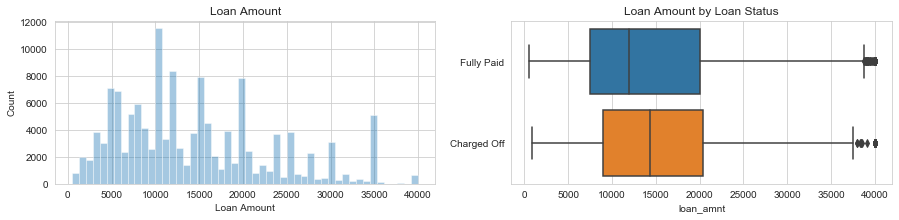

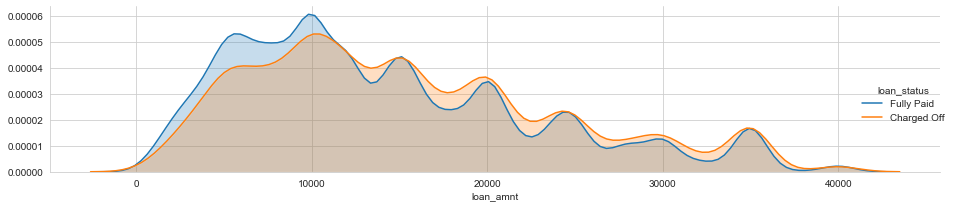

In [28]:
plot_var("loan_amnt", "Loan Amount", continuous=True)

"Charged off" loans seem to have higher loan amount. I will further examine the statistical difference in the later analysis.

### term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [29]:
df["term"].sample(5)

165183     36 months
141140     36 months
209402     36 months
188602     36 months
178608     36 months
Name: term, dtype: object

In [30]:
df["term"].value_counts(dropna=False)

 36 months    102163
 60 months     32237
Name: term, dtype: int64

In [31]:
df["term"] = df["term"].apply(lambda s: np.int8(s.split()[0]))

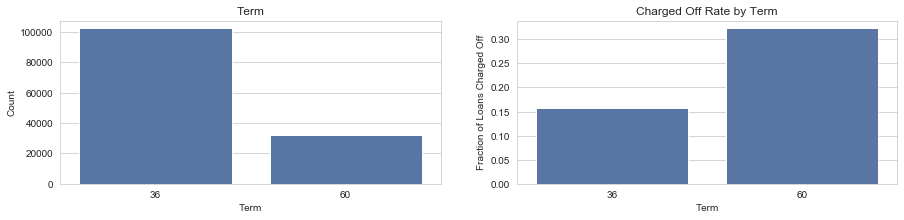

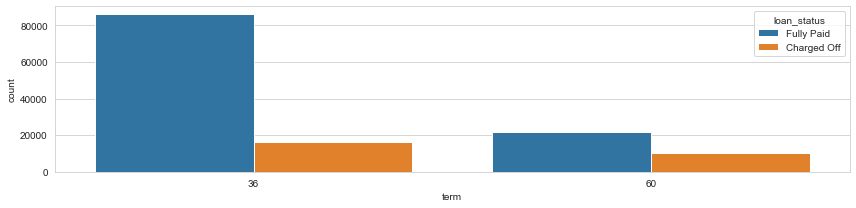

In [32]:
plot_var("term", "Term", continuous=False)

In [33]:
df["term"].value_counts(normalize=True)

36    0.760141
60    0.239859
Name: term, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

Compare the charge-off rate by loan period

In [34]:
df.groupby("term")["loan_status"].value_counts(normalize=True).loc[:, "Charged Off"]

term
36    0.157924
60    0.322363
Name: loan_status, dtype: float64

17% of the 36-month loans are charge off, while 33% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.

### int_rate
Data Dictionary: "Interest Rate on the loan."

In [35]:
df["int_rate"].describe()

count    134400.000000
mean         13.222646
std           4.749769
min           5.310000
25%           9.750000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%. 

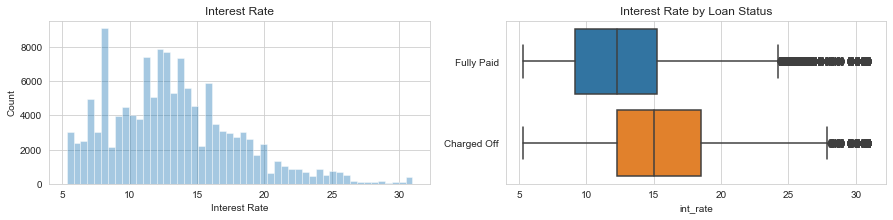

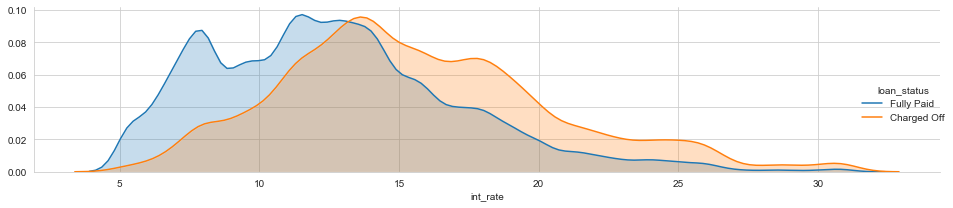

In [36]:
plot_var("int_rate", "Interest Rate", continuous=True)

The higher the interest rate is, the more likely for being charged off. 
There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis. 

### Outliers
- outliers can be exactly what we want to learn about, e.g., anomaly detection. 
- In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization. 
- Below, I use the modified [Z-score](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

drop_list = df.select_dtypes(exclude=['object']).columns

In [37]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding 
    to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median(
            [np.abs(y - median_y) for y in dataframe[col]]
        )
        modified_z_scores = [
            0.6745 * (y - median_y) / median_absolute_deviation_y
            for y in dataframe[col]
        ]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers


# Outliers_to_drop_z_score = outliers_modified_z_score(df,2,['loan_amnt', 'term', 'int_rate', 'installment',
# 'annual_inc', 'dti','fico_range_high', 'pub_rec', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc','earliest_cr_line_'])

In [38]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25, 75])
        # quartile_3 = np.percentile(dataframe[col], 75)

        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[
            (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
        ].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

In [39]:
df.groupby("loan_status")["int_rate"].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
Charged Off   26526.0  15.690366  4.891155  5.31  12.29  15.05  18.55  30.99
Fully Paid   107874.0  12.615839  4.512170  5.31   9.17  12.29  15.22  30.99

Any values > 75% percentile (18.99for "charged off", 15.31 for "Fully Paid") are defined as outliers. 

In [40]:
# df.groupby('loan_status')['int_rate'].value_counts()['Fully Paid'].sort_index()

In [41]:
df.loc[(df.int_rate > 15.61) & (df.loan_status == "Fully Paid")].shape[0]

23307

In [42]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == "Fully Paid")].shape[0]) / df[
    "loan_status"
].value_counts(normalize=False, dropna=False)[0]

0.21605762278213472

In [43]:
df.loc[(df.int_rate > 18.55) & (df.loan_status == "Charged Off")].shape[0] / df[
    "loan_status"
].value_counts(normalize=False, dropna=False)[1]

0.24368544069969086

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~27%. A bit too much to be dropped. I will keep these outliers for now.

### installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [44]:
df["installment"].describe()

count    134400.000000
mean        437.929832
std         261.194468
min          15.690000
25%         248.300000
50%         375.430000
75%         580.605000
max        1715.420000
Name: installment, dtype: float64

Installments range from \$5  to \$1715, with a median at \$377. 

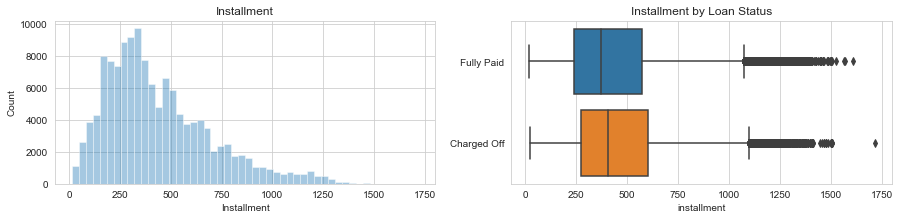

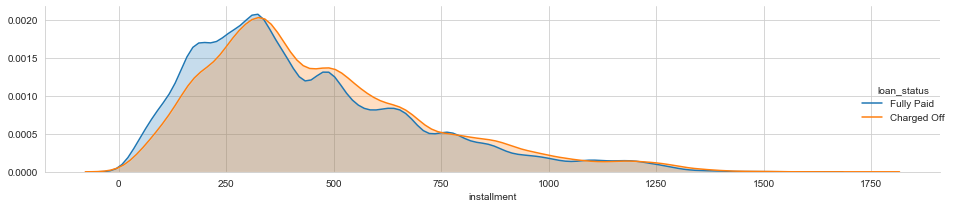

In [45]:
plot_var("installment", "Installment", continuous=True)

Charged-off loans tend to have higher installments but the difference of the mean values is very small (460 vs 431). Later, I will do a KS test to see if there are any statistical difference of "installment" between Fully Paid/charged off. 

In [46]:
df.groupby("loan_status")["installment"].describe()

count        mean         std    min     25%     50%     75%  \
loan_status                                                                    
Charged Off   26526.0  464.600964  261.748133  23.01  275.07  404.27  603.85   
Fully Paid   107874.0  431.371454  260.641621  15.69  240.92  368.90  573.24   

                 max  
loan_status           
Charged Off  1715.42  
Fully Paid   1607.80

### grade, sub_grade
Data Dictionary for grade: "assigned loan grade."
Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [47]:
sorted(df["grade"].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [48]:
print(sorted(df["sub_grade"].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

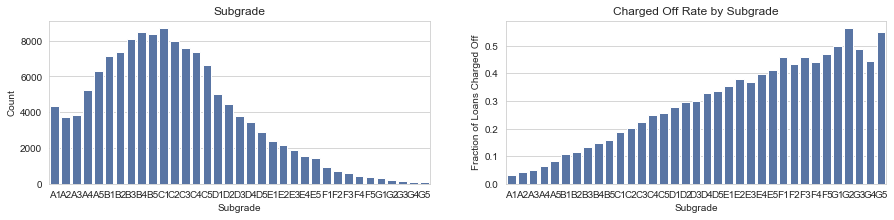

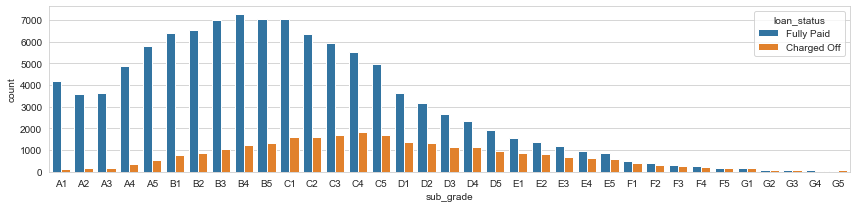

In [49]:
plot_var("sub_grade", "Subgrade", continuous=False)

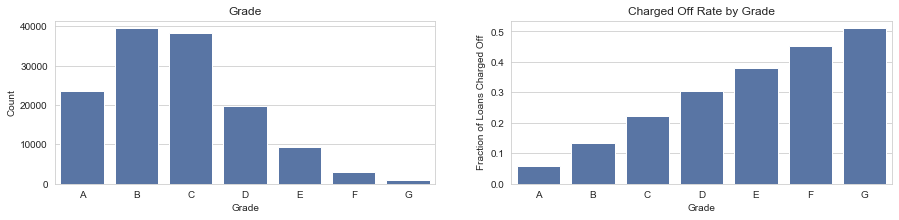

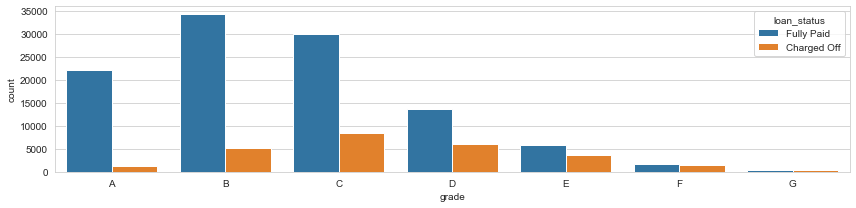

In [50]:
plot_var("grade", "Grade", continuous=False)

There is a trend of higher fraction of loans Charged off as the grade going from A to G, with some small variations among subgrades. 

In [51]:
# df.drop(labels='grade',axis=1,inplace=True)
drop_cols("grade")

### emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [52]:
df["emp_title"].describe()

count      125776
unique      56732
top       Teacher
freq         2133
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature. 

In [53]:
df["emp_title"].sample(5)

111522                  Med Sec
26671                 Attorney 
163136    Assistant Supervisor 
108265       IT Service Manager
66756       Public health nurse
Name: emp_title, dtype: object

In [54]:
drop_cols("emp_title")

### emp_length
<a id="emp_length"></a>
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [55]:
df["emp_length"].value_counts(dropna=False).sort_index()

1 year        8768
10+ years    44144
2 years      12165
3 years      10943
4 years       7931
5 years       8451
6 years       6253
7 years       5956
8 years       6097
9 years       5027
< 1 year     10766
NaN           7899
Name: emp_length, dtype: int64

There are 42k loans without the information on emp_length. Convert this feature to integers. 

In [56]:
df["emp_length"].replace("10+ years", "10 years", inplace=True)

In [57]:
df["emp_length"].replace("< 1 year", "0 years", inplace=True)

In [58]:
df["emp_length"].value_counts(dropna=False).sort_index()

0 years     10766
1 year       8768
10 years    44144
2 years     12165
3 years     10943
4 years      7931
5 years      8451
6 years      6253
7 years      5956
8 years      6097
9 years      5027
NaN          7899
Name: emp_length, dtype: int64

In [59]:
df.emp_length.map(lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0      10766
1       8768
10     44144
2      12165
3      10943
4       7931
5       8451
6       6253
7       5956
8       6097
9       5027
nan     7899
Name: emp_length, dtype: int64

In [60]:
df["emp_length"] = df.emp_length.map(lambda x: float(str(x).split()[0]))

In [61]:
df["emp_length"].sample(5)

214        4.0
86134      5.0
207378    10.0
15071     10.0
57450     10.0
Name: emp_length, dtype: float64

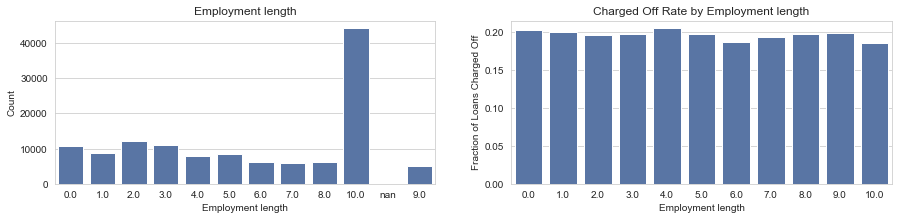

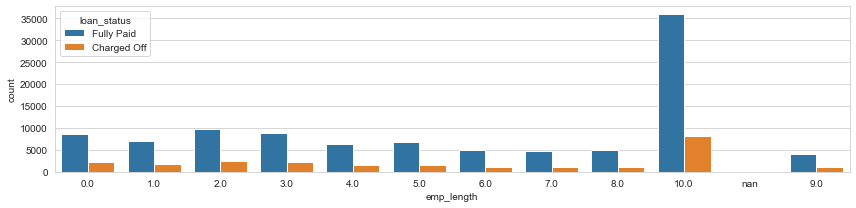

In [62]:
plot_var("emp_length", "Employment length", continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. Again, this will be further examined in a statistical test at the end. 

### home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [63]:
df["home_ownership"].value_counts()

MORTGAGE    66253
RENT        53635
OWN         14465
ANY            29
OTHER          15
NONE            3
Name: home_ownership, dtype: int64

Replace "ANY" & "None" with "OTHER". 

In [64]:
df["home_ownership"].replace(["NONE", "ANY"], "OTHER", inplace=True)

In [65]:
df["home_ownership"].value_counts()

MORTGAGE    66253
RENT        53635
OWN         14465
OTHER          47
Name: home_ownership, dtype: int64

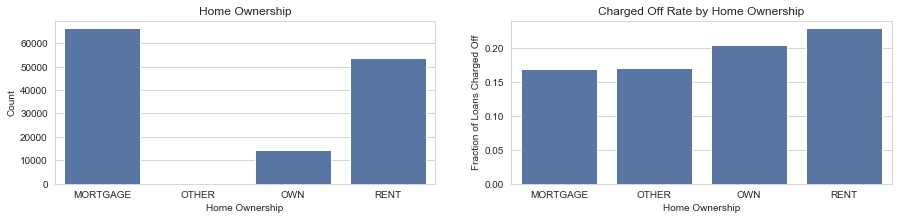

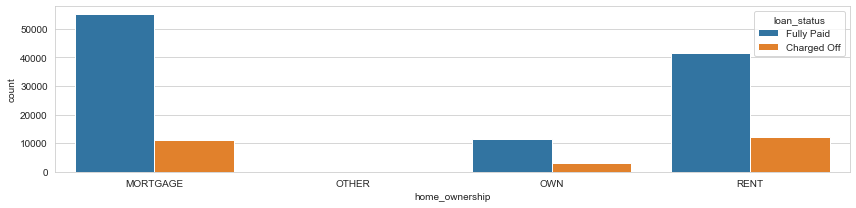

In [66]:
plot_var("home_ownership", "Home Ownership", continuous=False)

In [67]:
df.groupby("home_ownership")["loan_status"].value_counts(normalize=True).loc[
    :, "Charged Off"
]

home_ownership
MORTGAGE    0.169894
OTHER       0.170213
OWN         0.205392
RENT        0.229160
Name: loan_status, dtype: float64

There appear to be small differences in charge-off rates by home ownership status. Mortgage & OTHER has slightly less probability of Charged-Off. Because of the large numbers of observations in each category, these differences might be statistically significant.

### annual_inc
<a id="annual_inc"></a>
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [68]:
df["annual_inc"].describe()

count    1.344000e+05
mean     7.581034e+04
std      6.208853e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.225000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9M, with a median at \$75k, which doubles the national median individual income in the US (\$40k for males and \$25k for females). Due to the large range of variation, we log-transform the values.

In [69]:
df["annual_inc"] = df["annual_inc"].apply(lambda x: np.log10(x + 1))

In [70]:
df["annual_inc"].describe()

count    134400.000000
mean          4.811451
std           0.247251
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.964966
Name: annual_inc, dtype: float64

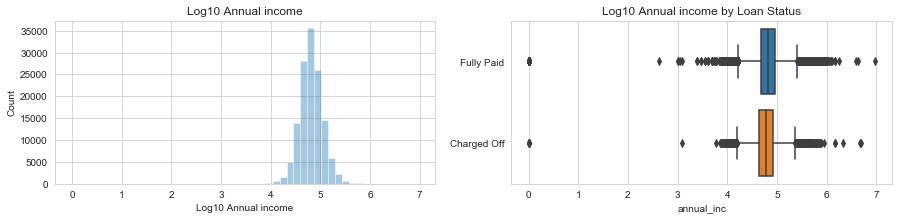

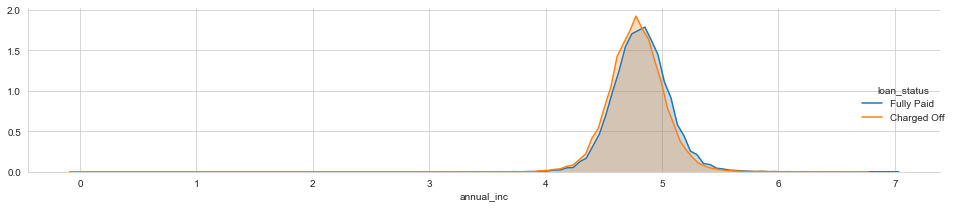

In [71]:
plot_var("annual_inc", "Log10 Annual income", continuous=True)

Let's look closer of the difference here

In [72]:
df.groupby("loan_status")["annual_inc"].describe()

count      mean       std  min       25%       50%       75%  \
loan_status                                                                    
Charged Off   26526.0  4.779803  0.241712  0.0  4.633479  4.778158  4.928831   
Fully Paid   107874.0  4.819233  0.247977  0.0  4.670255  4.812920  4.967084   

                  max  
loan_status            
Charged Off  6.686637  
Fully Paid   6.964966

For both cases, there are quite a few outliers (in the lower end). 

### verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [73]:
df["verification_status"].value_counts()

Source Verified    51786
Verified           41918
Not Verified       40696
Name: verification_status, dtype: int64

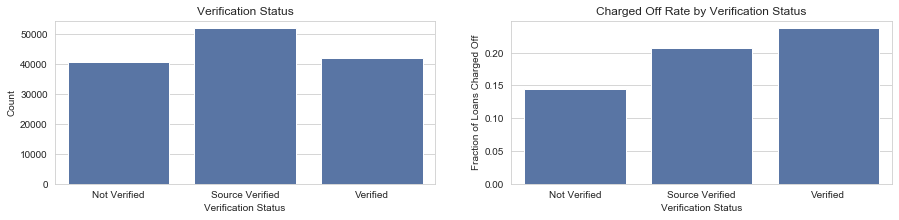

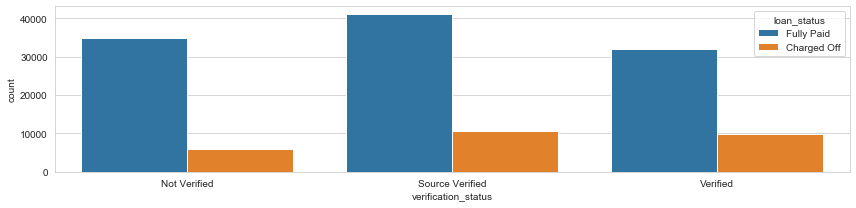

In [74]:
plot_var("verification_status", "Verification Status", continuous=False)

Surprisingly, verified loans have higher chance of being charged-Off. I would guess the opposite way.

### purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [75]:
df["purpose"].value_counts()

debt_consolidation    78061
credit_card           29607
home_improvement       8637
other                  7728
major_purchase         2926
small_business         1599
medical                1590
car                    1389
moving                  903
vacation                892
house                   699
wedding                 215
renewable_energy        112
educational              42
Name: purpose, dtype: int64

Now let's check the charged-off rates of purposes.

In [76]:
df.groupby("purpose")["loan_status"].value_counts(normalize=True)[
    :, "Charged Off"
].sort_values(ascending=False)

purpose
small_business        0.297061
renewable_energy      0.267857
moving                0.249169
educational           0.238095
medical               0.218239
debt_consolidation    0.209144
other                 0.207686
house                 0.201717
vacation              0.183857
major_purchase        0.183527
home_improvement      0.170777
credit_card           0.167866
car                   0.141109
wedding               0.116279
Name: loan_status, dtype: float64

We see that, 30% of the loans for small_business are charged off, but only 12% of wedding are charged Off.

### title
Data Dictionary: "The loan title provided by the borrower."

In [77]:
df["title"].describe()

count                 132759
unique                  8476
top       Debt consolidation
freq                   66060
Name: title, dtype: object

In [78]:
df["title"].value_counts().head(10)

Debt consolidation         66060
Credit card refinancing    25047
Home improvement            7409
Other                       6638
Major purchase              2425
Debt Consolidation          1555
Medical expenses            1372
Business                    1241
Car financing               1075
Vacation                     791
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column. 

In [79]:
drop_cols("title")

### zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."  
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."  

In [80]:
df["zip_code"].describe()

count     134400
unique       881
top        945xx
freq        1448
Name: zip_code, dtype: object

In [81]:
df["addr_state"].describe()

count     134400
unique        50
top           CA
freq       19501
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code". 

In [82]:
drop_cols("zip_code")

In [83]:
df.groupby("addr_state")["loan_status"].value_counts(normalize=True)[
    :, "Charged Off"
].sort_values(ascending=False)

addr_state
NE    0.259740
SD    0.257246
MS    0.251956
OK    0.248082
AR    0.243697
LA    0.233962
TN    0.227273
AL    0.226519
NV    0.224246
IN    0.218978
NY    0.217380
DE    0.217033
MD    0.213325
MO    0.211429
FL    0.210119
PA    0.206223
KY    0.204618
NJ    0.204470
NC    0.203793
OH    0.201449
ID    0.198830
AZ    0.196802
AK    0.195719
MN    0.195540
MI    0.193869
VA    0.193029
CA    0.192913
TX    0.192712
NM    0.191571
IL    0.191068
RI    0.184514
GA    0.182106
WI    0.181924
HI    0.180473
MA    0.178840
ND    0.176871
CT    0.175612
SC    0.165957
MT    0.165854
UT    0.165834
WV    0.164835
WA    0.161067
CO    0.154920
KS    0.151292
OR    0.149227
NH    0.147920
WY    0.142857
DC    0.136499
ME    0.129310
VT    0.120879
Name: loan_status, dtype: float64

MS has the highest fraction of Charged Off (0.28), whereas DC has the lowest fraction at 0.13. 

### dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [84]:
df["dti"].describe()

count    134363.000000
mean         18.303344
std          10.287207
min           0.000000
25%          11.800000
50%          17.660000
75%          24.090000
max         999.000000
Name: dti, dtype: float64

The values of -1 or 999 are probably outliers. Let's look at its histogram .

Text(0.5, 1.0, 'DTI by loan status')

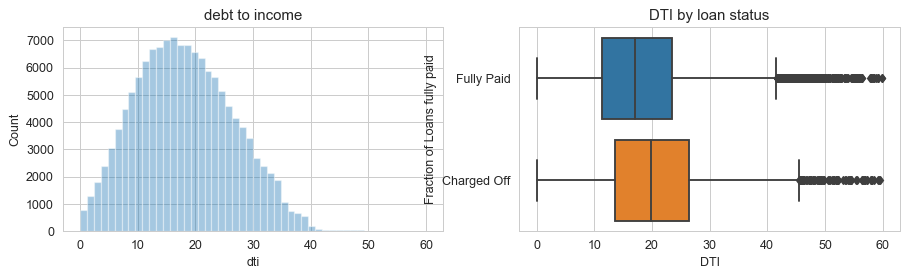

In [85]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
sns.distplot(df.loc[df["dti"].notnull() & (df["dti"] < 60), "dti"], kde=False, ax=ax1)
ax1.set_xlabel("dti")
ax1.set_ylabel("Count")
ax1.set_title("debt to income")
sns.boxplot(
    x=df.loc[df["dti"].notnull() & (df["dti"] < 60), "dti"],
    y="loan_status",
    data=df,
    ax=ax2,
)
ax2.set_xlabel("DTI")
ax2.set_ylabel("Fraction of Loans fully paid")
ax2.set_title("Fully paid rate by debt to income")
ax2.set_title("DTI by loan status")

In [86]:
(df["dti"] > 40).sum() / (df["dti"]).sum()

0.0002927671604637532

In [87]:
(df["dti"] > 40).sum()

720

Very few (0.01%) outliers with dti > 60. 
From the figure it seems that the Charged Off loans have higher DTI. Let's check. 

In [88]:
df.groupby("loan_status")["dti"].median()

loan_status
Charged Off    19.90
Fully Paid     17.12
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off 

### open_acc
Data Dictionary: "The number of open credit lines in the borrower's credit file."

In [89]:
df["open_acc"].describe()

count    134400.000000
mean         11.576443
std           5.461914
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          84.000000
Name: open_acc, dtype: float64

In [90]:
# plt.figure(figsize=(10,3), dpi=90)
# sns.countplot(df['open_acc'], order=sorted(df['open_acc'].unique()),saturation=1)
# _, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
# plt.title('Number of Open Credit Lines')

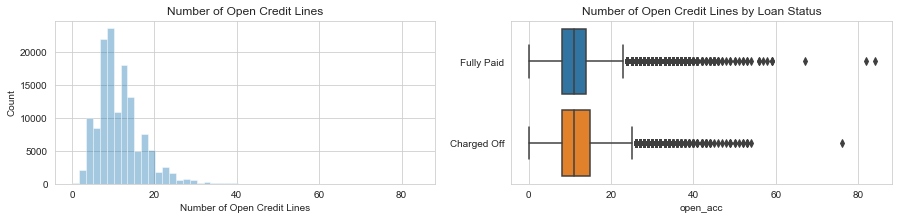

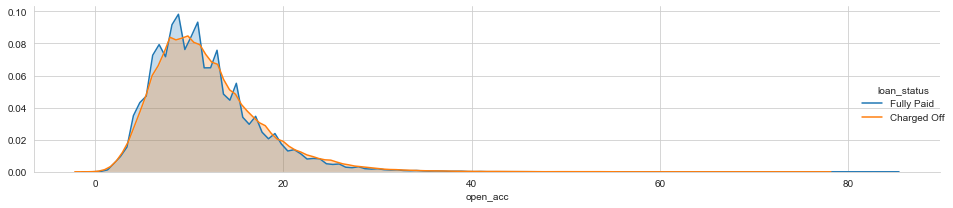

In [91]:
plot_var("open_acc", "Number of Open Credit Lines", continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

In [92]:
df.groupby("loan_status")["open_acc"].describe()

count       mean       std  min  25%   50%   75%   max
loan_status                                                           
Charged Off   26526.0  11.943565  5.676801  0.0  8.0  11.0  15.0  76.0
Fully Paid   107874.0  11.486169  5.403974  0.0  8.0  11.0  14.0  84.0

### earliest_cr_line
<a id="earliest_cr_line"></a>
Data Dictionary: "The month the borrower's earliest reported credit line was opened."

Rather than converting it to a date, I will use a scalar to describe the length of time since the first line of credit. If all other variables are held equal, the longer you have had lines of credit the better. 

In [93]:
df["earliest_cr_line"].sample(5)

73428     May-2002
187290    Sep-1986
102246    Aug-2007
91980     Dec-2001
89917     Jan-2002
Name: earliest_cr_line, dtype: object

In [94]:
df["earliest_cr_line"].describe()

count       134400
unique         662
top       Aug-2001
freq           991
Name: earliest_cr_line, dtype: object

In [95]:
df["earliest_cr_line"].isnull().any()

False

In [96]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime("%Y-%m-%d")
df.earliest_cr_line = df.earliest_cr_line.apply(
    lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)), "D").astype(int)) / -365
)

df.earliest_cr_line.shape

(134400,)

In [97]:
df.earliest_cr_line.sample(5)

77357     16.210959
218939    22.547945
21190      8.120548
215915    17.964384
147666    16.879452
Name: earliest_cr_line, dtype: float64

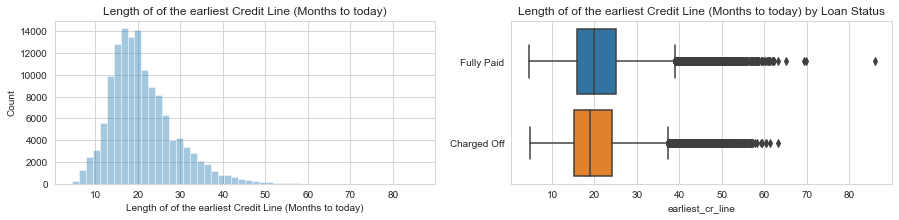

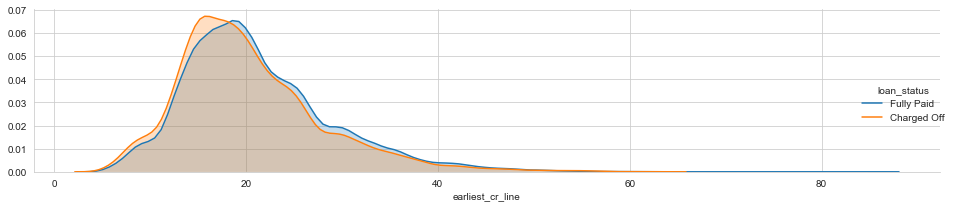

In [98]:
plot_var(
    "earliest_cr_line",
    "Length of of the earliest Credit Line (Months to today)",
    continuous=True,
)

Borrowers who charged off have opened their first credit line more recently, although their medians are almost the same.

In [99]:
df.groupby("loan_status")["earliest_cr_line"].describe()

count       mean       std       min        25%        50%  \
loan_status                                                                  
Charged Off   26526.0  20.293677  7.529210  4.871233  15.208219  18.964384   
Fully Paid   107874.0  21.144737  7.632025  4.536986  15.876712  19.797260   

                   75%        max  
loan_status                        
Charged Off  24.046575  63.156164  
Fully Paid   25.131507  85.926027

### fico_range_low, fico_range_high
<a id="fico"></a>
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."  
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."

**** FICO: A FICO score is a type of credit score created by the Fair Isaac Corporation. Lenders use borrowers' FICO scores along with other details on borrowers' credit reports to assess credit risk and determine whether to extend credit. FICO scores take into account various factors in five areas to determine creditworthiness: payment history, current level of indebtedness, types of credit used, length of credit history, and new credit accounts.****

In [100]:
df[["fico_range_low", "fico_range_high"]].describe()

fico_range_low  fico_range_high
count   134400.000000    134400.000000
mean       696.135045       700.135171
std         31.812364        31.812958
min        660.000000       664.000000
25%        670.000000       674.000000
50%        690.000000       694.000000
75%        710.000000       714.000000
max        845.000000       850.000000

Check the correlation between the two:

In [101]:
df[["fico_range_low", "fico_range_high"]].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

These two are highly correlated, therefore we only need to keep one. We create a new feature, "fico_score" which is the mean value of the "fico_range_low" and "fico_range_high"

In [102]:
df["fico_score"] = (df["fico_range_low"] + df["fico_range_high"]) / 2.0

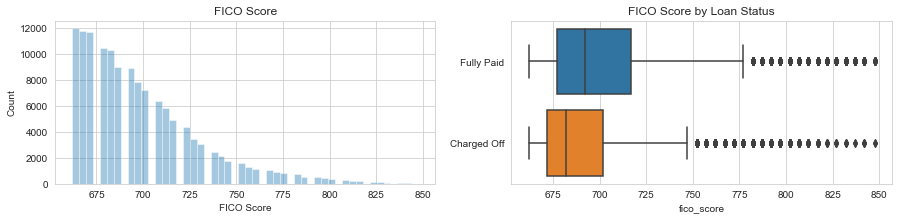

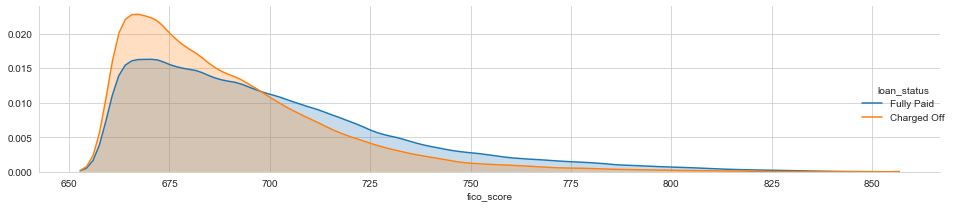

In [103]:
plot_var("fico_score", "FICO Score", continuous=True)

There is noticeable difference in FICO scores between fully paid and charged-off loans.

**Thought 1:** A side note, what are the missing values in the specific FICO scores (i.e., ~620, 700, 730)? where are they from?

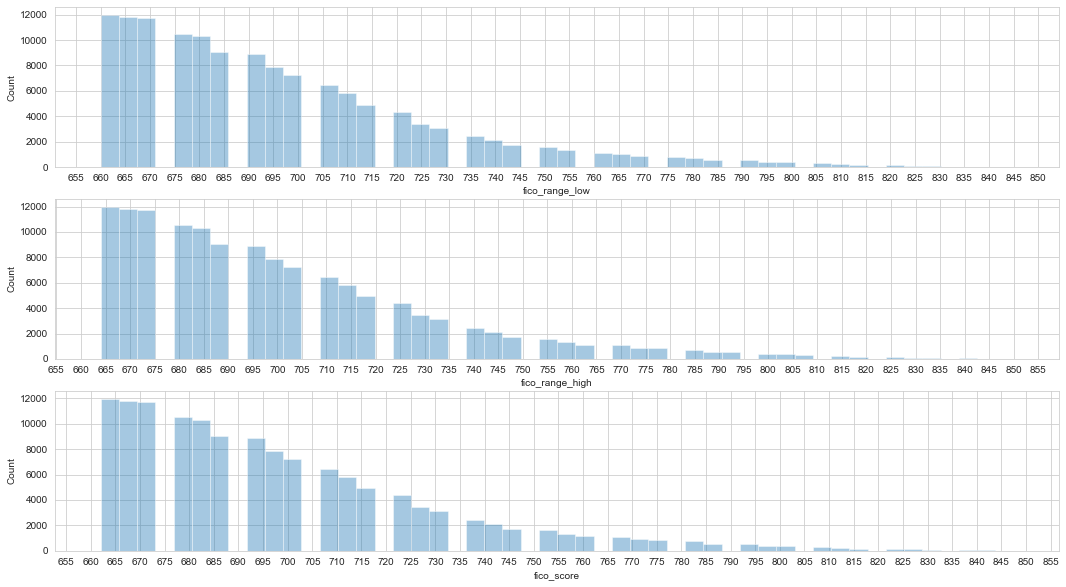

In [104]:
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(18, 10))
sns.distplot(
    df.loc[df["fico_range_low"].notnull(), "fico_range_low"], kde=False, ax=ax1
)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.set_ylabel("Count")

sns.distplot(
    df.loc[df["fico_range_high"].notnull(), "fico_range_high"], kde=False, ax=ax2
)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylabel("Count")

sns.distplot(df.loc[df["fico_score"].notnull(), "fico_score"], kde=False, ax=ax3)
ax3.set_ylabel("Count")
ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [105]:
df["fico_range_low"].value_counts().sort_index().head(5)

660.0    11988
665.0    11806
670.0    11709
675.0    10512
680.0    10330
Name: fico_range_low, dtype: int64

In [106]:
df["fico_range_high"].value_counts().sort_index().head(5)

664.0    11988
669.0    11806
674.0    11709
679.0    10512
684.0    10330
Name: fico_range_high, dtype: int64

In [107]:
df["fico_score"].value_counts().sort_index().head(5)

662.0    11988
667.0    11806
672.0    11709
677.0    10512
682.0    10330
Name: fico_score, dtype: int64

**Thought 2:** As FICO score itself stands out as an overall important factor. I would like to check the most significant contributors `(acct number, earliest credit card, and the ratio of total monthly debt payments on the total debt obligations)` to the FICO score, based on my own knowledge. 

In [108]:
df[["fico_score", "open_acc", "earliest_cr_line", "dti"]].corr()

fico_score  open_acc  earliest_cr_line       dti
fico_score          1.000000  0.015963          0.099028 -0.066064
open_acc            0.015963  1.000000          0.126702  0.241492
earliest_cr_line    0.099028  0.126702          1.000000  0.021852
dti                -0.066064  0.241492          0.021852  1.000000

In [109]:
plot_df = df.query("fico_score > 650")[:3000]
# sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5})
# g = sns.jointplot(x="earliest_cr_line", y="fico_score", data=plot_df, kind='kde')
# g.set(xlim=(2.5, 28),ylim=(630, 880),alpha = .5)
# g.savefig('1.png',transparent=True)

Text(0.5, 0, 'fico_score')

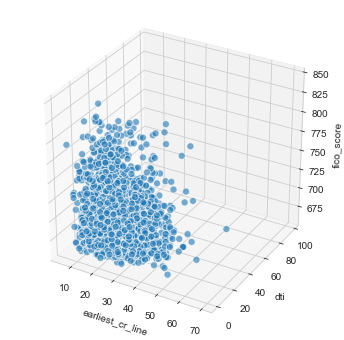

In [110]:
%matplotlib inline
# Visualizing 3-D numeric data with Scatter Plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13, 6))
# fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1 = fig.add_subplot(121, projection="3d")

xs = plot_df["earliest_cr_line"]
ys = plot_df["dti"]
zs = plot_df["fico_score"]
ax1.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors="w", cmap="greens")

ax1.set_xlabel("earliest_cr_line")
ax1.set_ylabel("dti")
ax1.set_zlabel("fico_score")

In [111]:
%matplotlib notebook

# Group by loan_status
fig = plt.figure(figsize=(13, 6))
ax2 = fig.add_subplot(111, projection="3d")

xs = plot_df["earliest_cr_line"]
ys = plot_df["dti"]
zs = plot_df["fico_score"]

data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = [
    "red" if wt == "Charged Off" else "green" for wt in list(plot_df["loan_status"])
]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax2.scatter(x, y, z, alpha=0.4, c=color, edgecolors="none", s=30)
ax2.legend(["Fully Paid", "Charged Off"], markerscale=2.0)
ax2.set_xlabel("earliest_cr_line")
ax2.set_ylabel("dti")
ax2.set_zlabel("fico_score")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.05, 'Fico_score - earliest_cr_line - DTI')

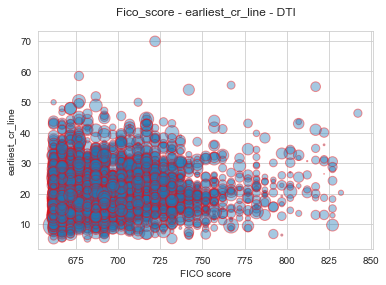

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualizing 3-D numeric data with a bubble chart
plt.scatter(zs, xs, s=ys * 5, alpha=0.4, edgecolors="red")

plt.xlabel("FICO score")
plt.ylabel("earliest_cr_line")
plt.title("Fico_score - earliest_cr_line - DTI", y=1.05)

**Thought 3:** As I know that FICO score is a very important feature, I would like to check the correlations between FICO score, int_rate and the term, 3 of the most important features that show different distributions between "Charged-off" and "fully paid" loans from previous EDA.

In [113]:
df[["fico_score", "int_rate", "term"]].corr()

fico_score  int_rate      term
fico_score    1.000000 -0.404606 -0.000850
int_rate     -0.404606  1.000000  0.416423
term         -0.000850  0.416423  1.000000

It seems that the higher the fico_score is, the lower the int_rate. Let's take a look at their correlations.

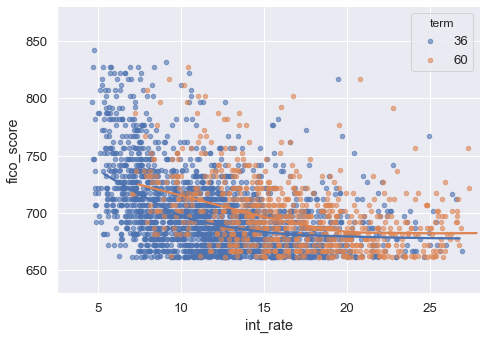

In [114]:
plot_df = df.query("fico_score > 650 & int_rate <28")[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5})

g = sns.lmplot(
    "int_rate",
    "fico_score",
    x_jitter=0.7,
    y_jitter=0.1,
    data=plot_df,
    hue="term",
    lowess=True,
    size=5,
    aspect=1.4,
    legend_out=False,
    scatter_kws={"s": 20, "alpha": 0.6},
)

g.set(xlim=(2.5, 28), ylim=(630, 880), alpha=0.5)

# g.savefig('1.png',transparent=True)

short-term loans have higher "fico_score" especially at lower "int_rate". I will explore the correlations between variables in the later analysis.

In [115]:
drop_cols(["fico_range_high", "fico_range_low"])

### pub_rec
Data Dictionary: "Number of derogatory public records."

In [116]:
df["pub_rec"].describe()

count    134400.000000
mean          0.215662
std           0.587876
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: pub_rec, dtype: float64

In [117]:
df["pub_rec"].value_counts().sort_values(ascending=False)

0.0     111630
1.0      19065
2.0       2388
3.0        765
4.0        290
5.0        121
6.0         60
7.0         35
8.0         17
9.0         10
11.0         7
13.0         3
10.0         3
12.0         2
18.0         1
28.0         1
22.0         1
15.0         1
Name: pub_rec, dtype: int64

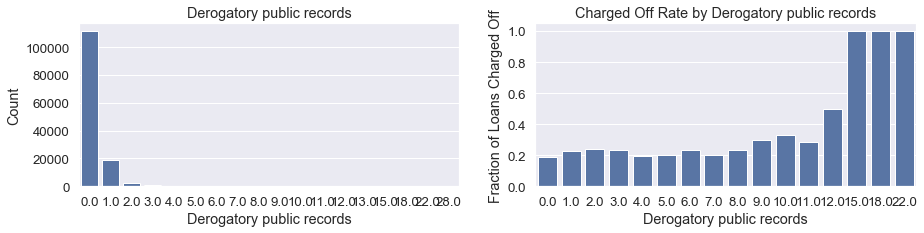

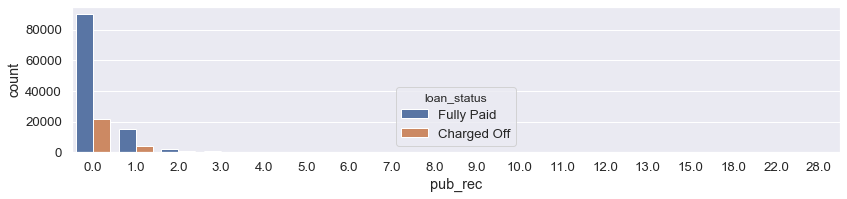

In [118]:
plot_var("pub_rec", "Derogatory public records", continuous=False)

"pub_rec" > 11 have significant of Charged-Off rate. However, it's affected by low-counts. If we look at the overall statistics, the mean difference in "pub_Rec" is just 0.04 for fully paid/charged Off

In [119]:
df.groupby("loan_status")["pub_rec"].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off   26526.0  0.248247  0.640696  0.0  0.0  0.0  0.0  22.0
Fully Paid   107874.0  0.207650  0.573863  0.0  0.0  0.0  0.0  28.0

What if we group the few bins with lower values together into 1 bin?

In [120]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x > 2.0 else x)

In [121]:
df["pub_rec"].value_counts().sort_values(ascending=False)

0.0    111630
1.0     19065
2.0      2388
3.0      1317
Name: pub_rec, dtype: int64

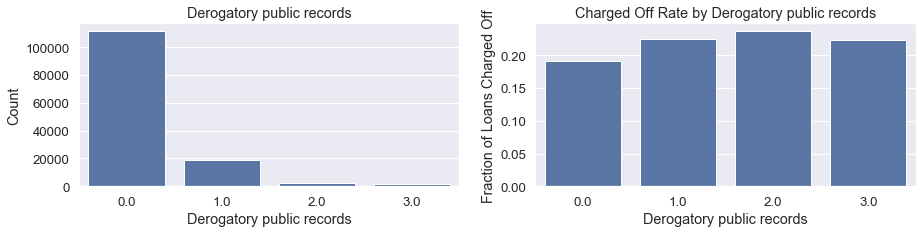

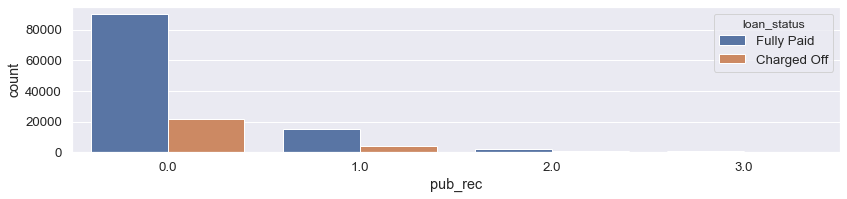

In [122]:
plot_var("pub_rec", "Derogatory public records", continuous=False)

In [123]:
df.groupby("loan_status")["pub_rec"].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
Charged Off   26526.0  0.237314  0.538896  0.0  0.0  0.0  0.0  3.0
Fully Paid   107874.0  0.199279  0.500193  0.0  0.0  0.0  0.0  3.0

After grouping, it is clear that: pub_rec are mostly 0 & 1; pub_rec with 1 and higher have higher chance of being charged off than pub_rec of 0. 

### pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

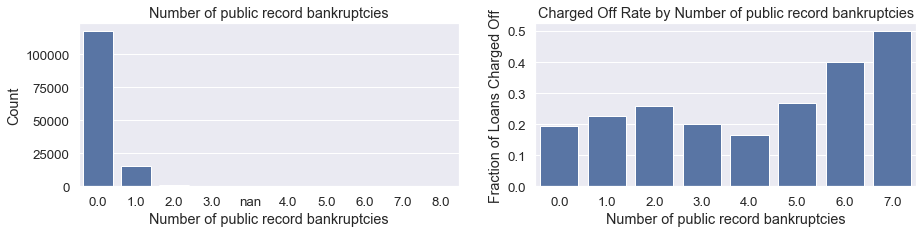

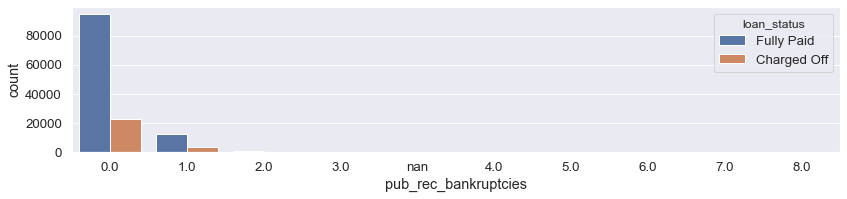

In [124]:
plot_var(
    "pub_rec_bankruptcies", "Number of public record bankruptcies", continuous=False
)

In [125]:
df[["pub_rec", "pub_rec_bankruptcies"]].corr()

pub_rec  pub_rec_bankruptcies
pub_rec               1.000000              0.734013
pub_rec_bankruptcies  0.734013              1.000000

"pub_rec" and "pub_rec_bankruptcies" are highly correlated. could only feed one of them into the modeling.

### revol_bal
Data Dictionary: "Total credit revolving balance."

In [126]:
df["revol_bal"].describe()

count    134400.000000
mean      16144.652813
std       21356.548029
min           0.000000
25%        5949.750000
50%       11123.500000
75%       19682.250000
max      853207.000000
Name: revol_bal, dtype: float64

In [127]:
df["revol_bal"] = df["revol_bal"].apply(lambda x: np.log10(x + 1))

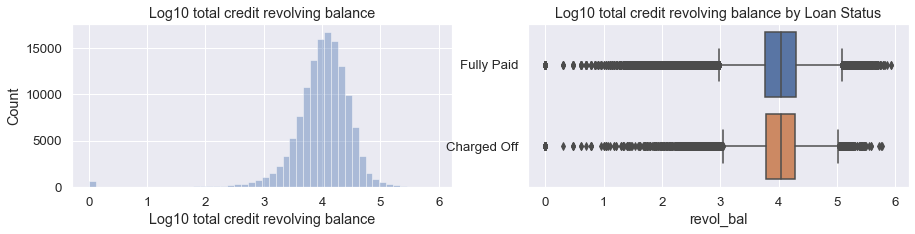

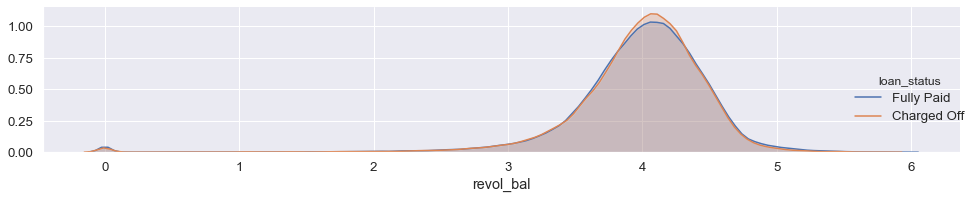

In [128]:
plot_var("revol_bal", "Log10 total credit revolving balance", continuous=True)

### revol_util
Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [129]:
df["revol_util"].describe()

count    134313.000000
mean         51.977568
std          24.516190
min           0.000000
25%          33.700000
50%          52.300000
75%          70.900000
max         165.800000
Name: revol_util, dtype: float64

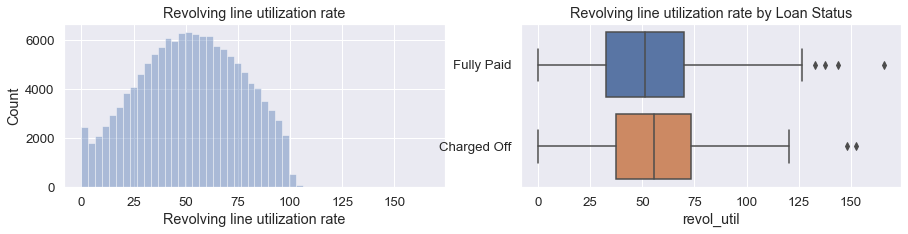

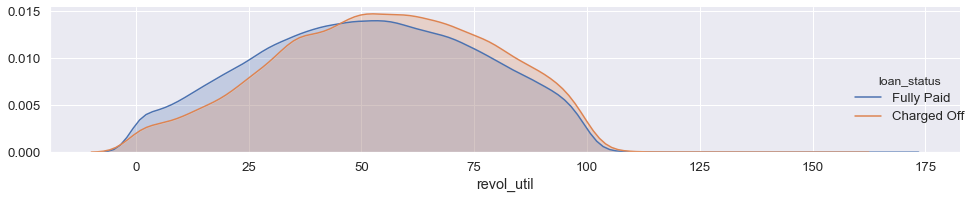

In [130]:
plot_var("revol_util", "Revolving line utilization rate", continuous=True)

In [131]:
df.groupby("loan_status")["revol_util"].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
Charged Off   26510.0  55.040880  23.802730  0.0  37.6  55.7  73.4  152.6
Fully Paid   107803.0  51.224264  24.630292  0.0  32.7  51.5  70.2  165.8

Charged Off loans tend to have higher revol_util.

### total_acc
Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [132]:
df["total_acc"].describe()

count    134400.000000
mean         24.974293
std          12.005403
min           2.000000
25%          16.000000
50%          23.000000
75%          32.000000
max         162.000000
Name: total_acc, dtype: float64

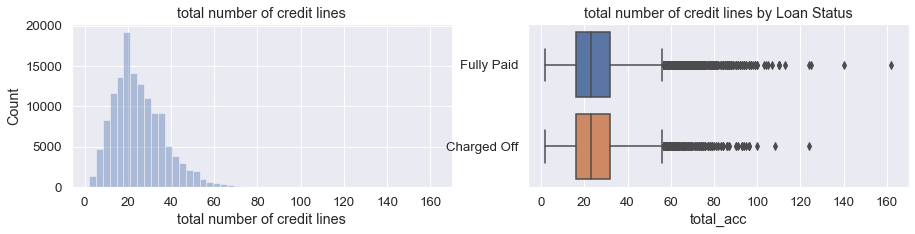

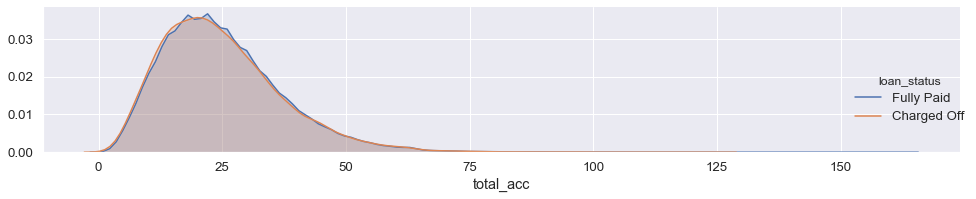

In [133]:
plot_var("total_acc", "total number of credit lines", continuous=True)

### initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F  (whole vs. fractional)

In [134]:
df["initial_list_status"].value_counts()

w    77958
f    56442
Name: initial_list_status, dtype: int64

Half of the granted loans are in whole amount and half are in fractional amount. "Whole" has higher fraction of Charged-Off.

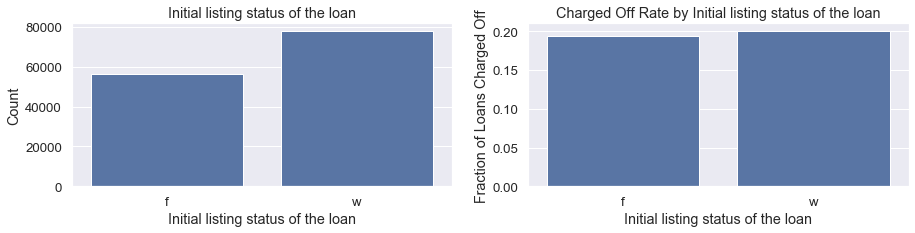

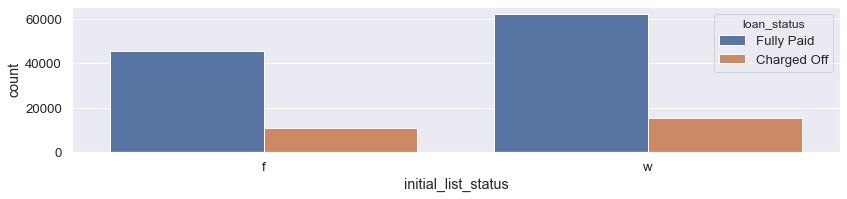

In [135]:
plot_var("initial_list_status", "Initial listing status of the loan", continuous=False)

### policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [136]:
df["policy_code"].value_counts()

1.0    134400
Name: policy_code, dtype: int64

All values are the same; drop this feature. 

In [137]:
drop_cols("policy_code")

### application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [138]:
df["application_type"].value_counts()

Individual    131702
Joint App       2698
Name: application_type, dtype: int64

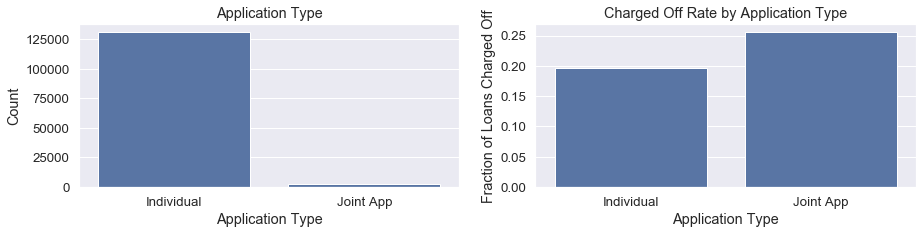

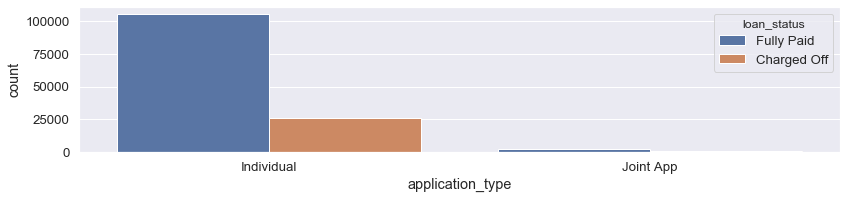

In [139]:
plot_var("application_type", "Application Type", continuous=False)

The majority of the loans are individual applications and they are more possible to be charged off than joint app.

### mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

In [140]:
df["mo_sin_old_il_acct"].describe()

count    124009.000000
mean        125.945431
std          52.271943
min           0.000000
25%          98.000000
50%         129.000000
75%         153.000000
max         999.000000
Name: mo_sin_old_il_acct, dtype: float64

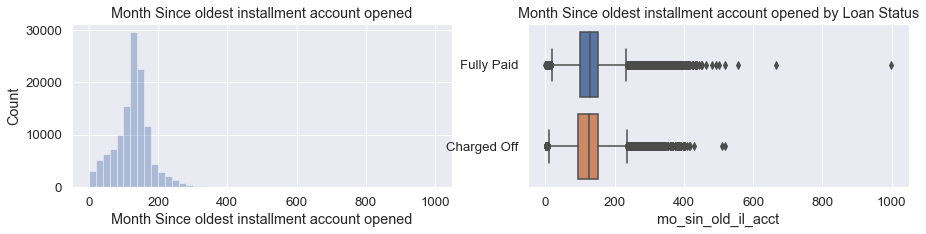

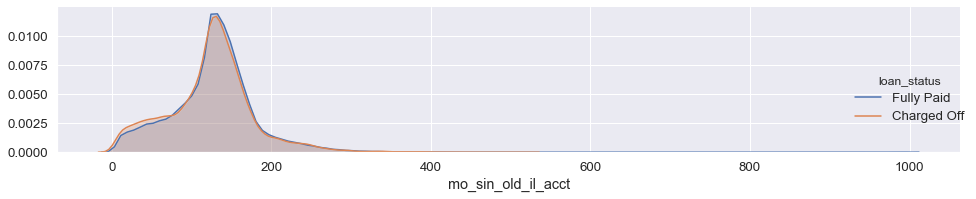

In [141]:
plot_var(
    "mo_sin_old_il_acct",
    "Month Since oldest installment account opened",
    continuous=True,
)

### mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

In [142]:
df["mo_sin_old_rev_tl_op"].describe()

count    127750.000000
mean        181.674849
std          94.442583
min           4.000000
25%         117.000000
50%         164.000000
75%         230.000000
max         764.000000
Name: mo_sin_old_rev_tl_op, dtype: float64

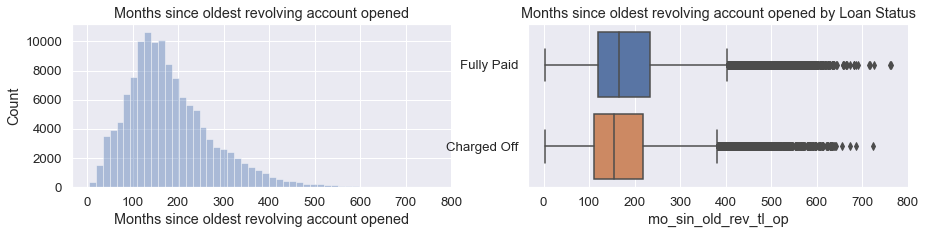

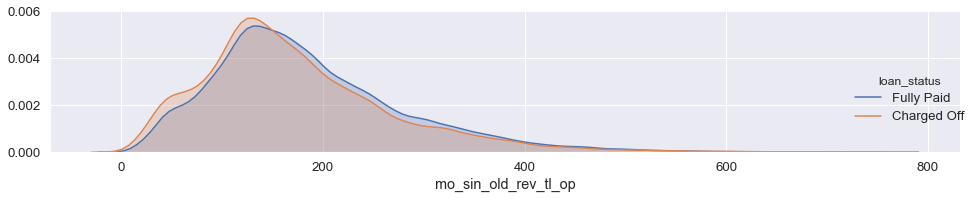

In [143]:
plot_var(
    "mo_sin_old_rev_tl_op",
    "Months since oldest revolving account opened",
    continuous=True,
)

### mort_acc
Data Dictionary: "Number of mortgage accounts."

In [144]:
df["mort_acc"].describe()

count    129734.000000
mean          1.667589
std           1.996976
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          32.000000
Name: mort_acc, dtype: float64

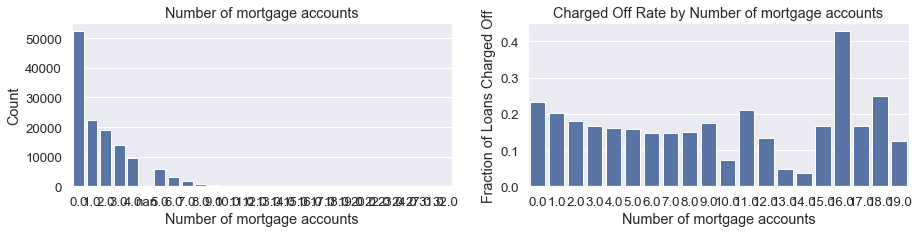

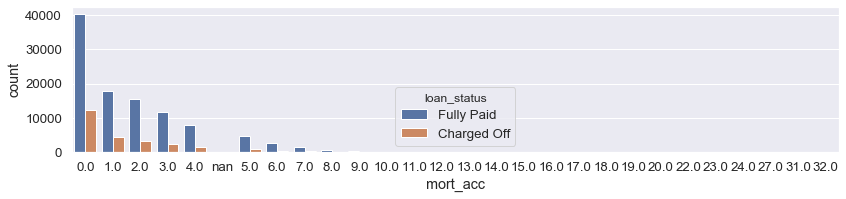

In [145]:
plot_var("mort_acc", "Number of mortgage accounts", continuous=False)

In [146]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

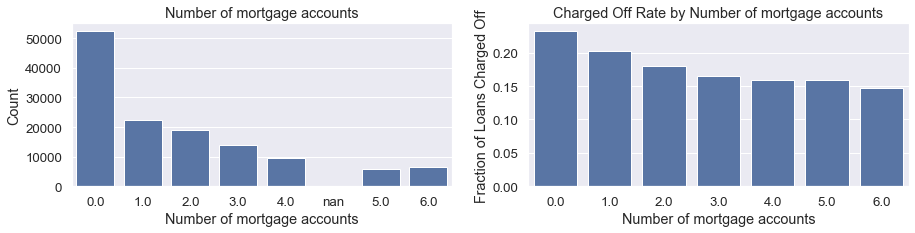

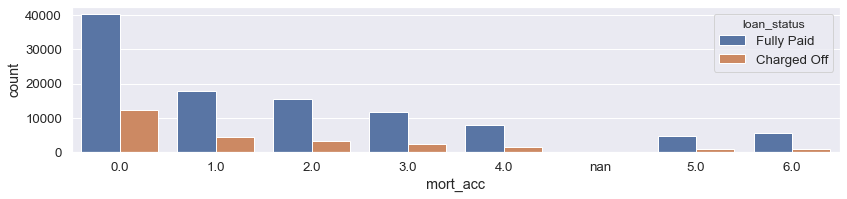

In [147]:
plot_var("mort_acc", "Number of mortgage accounts", continuous=False)

The more the number of mortgage accounts, the lower fraction of loans charged off. 

In [148]:
df.groupby("loan_status")["mort_acc"].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                       
Charged Off   25874.0  1.344129  1.696756  0.0  0.0  1.0  2.0  6.0
Fully Paid   103860.0  1.675900  1.825190  0.0  0.0  1.0  3.0  6.0

### 4.4 remove irelevent features!
Besides the formentioned points after culling the NaN dominated columns, there are still a lot of features. Some will have useful info, others not. At this point I will carefully inspect the remaining features and weeded out any column that I think may be well useless. My main criteria is whether a feature is dominated by a single value (> 80%)

1. addr_state: I really don't think that the state and location of aperson will determine if they will repay a loan. Although, I could be wrong ....
2. application_type: was >99% INDIVIDUAL


In [149]:
del_cols = [
    "addr_state",
    "application_type",
]
df.shape

(134400, 28)

In [150]:
drop_cols(del_cols)
df.shape

(134400, 26)

## 5 Feature Selection II: Statistical Overview 
<a id="corr"></a>
I have looked at the features individually. Now I will do some overall statistical tests for all the features on their distributions, correlations, etc.

### 5.1 Convert target variable to 0/1 indicator
<a id="converttarget"></a>
It's more convenient/useful to convert our target variable to numerical variable. Fully Paid = 0, Charged Off = 1

In [151]:
# Next, I will convert the "loan_status" column to a 0/1 "charged off" column. Fully Paid:0 Charged Off: 1
df["Charged_Off"] = df["loan_status"].apply(lambda s: np.float(s == "Charged Off"))
drop_cols("loan_status")

### 5.2 Hypothesis Testing
<a id="kstest"></a>

Here I can group the loans to "fully paid" & "charged-off", and then use hypothesis tests to compare the two distributions of each feature. 

If the test statistic is small or the [p-value](https://en.wikipedia.org/wiki/P-value) is high (>0.05, 95% confidence level), we cannot reject the null hypothesis that the distributions of the two samples are the same and if if p<0.05, different distributions. 

[K-S](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) Tests, Z Tests and chi-squared Tests:
- Numerical features: We can use K-S tests
- Features with only 0 or 1 values, we can use proportion Z tests to check whether the difference in mean values is statistically significant. 
- For categorical features, we can use [chi-squared](https://en.wikipedia.org/wiki/Null_hypothesis) Tests

In [152]:
list_float = df.select_dtypes(exclude=["object"]).columns

In [153]:
def run_KS_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    print(feature + ":")
    print(ks_2samp(dist1, dist2), "\n")

In [154]:
from statsmodels.stats.proportion import proportions_ztest


def run_proportion_Z_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature + ":")
    print("z-score = {}; p-value = {}".format(z_score, p_value), "\n")

In [155]:
from scipy.stats import chi2_contingency


def run_chi2_test(df, feature):

    dist1 = (
        df.loc[df.loan_status == "Fully Paid", feature]
        .value_counts()
        .sort_index()
        .tolist()
    )
    dist2 = (
        df.loc[df.loan_status == "Charged Off", feature]
        .value_counts()
        .sort_index()
        .tolist()
    )
    chi2, p, dof, expctd = chi2_contingency([dist1, dist2])
    print(feature + ":")
    print("chi-square test statistic:", chi2)
    print("p-value", p, "\n")

In [156]:
for i in list_float:
    run_KS_test(i)

Unnamed: 0:
Ks_2sampResult(statistic=0.03444144417785794, pvalue=2.315168796375931e-22) 

loan_amnt:
Ks_2sampResult(statistic=0.0834317217213677, pvalue=3.759342111734792e-129) 

term:
Ks_2sampResult(statistic=0.18926179456133863, pvalue=0.0) 

int_rate:
Ks_2sampResult(statistic=0.26673230491577266, pvalue=0.0) 

installment:
Ks_2sampResult(statistic=0.07243453040921344, pvalue=1.8772428459634464e-97) 

emp_length:
Ks_2sampResult(statistic=0.025504385877452518, pvalue=1.870357698361293e-12) 

annual_inc:
Ks_2sampResult(statistic=0.07208547573012969, pvalue=1.6084176279421974e-96) 

dti:
Ks_2sampResult(statistic=0.11924020097051485, pvalue=2.3210038997050157e-263) 

earliest_cr_line:
Ks_2sampResult(statistic=0.057317217754658645, pvalue=3.5251877262107184e-61) 

open_acc:
Ks_2sampResult(statistic=0.033947586785771255, pvalue=9.75366253035133e-22) 

pub_rec:
Ks_2sampResult(statistic=0.03029376842537357, pvalue=2.137579745898725e-17) 

revol_bal:
Ks_2sampResult(statistic=0.015542400395357

OK, it seems that all of these features have different distributions for Fully Paid/Charged Off.

### 5.3 Pearson Correlation
<a id="pearson"></a>

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134400 entries, 1 to 226068
Data columns (total 26 columns):
Unnamed: 0              134400 non-null int64
loan_amnt               134400 non-null float64
term                    134400 non-null int64
int_rate                134400 non-null float64
installment             134400 non-null float64
sub_grade               134400 non-null object
emp_length              126501 non-null float64
home_ownership          134400 non-null object
annual_inc              134400 non-null float64
verification_status     134400 non-null object
issue_d                 134400 non-null object
purpose                 134400 non-null object
dti                     134363 non-null float64
earliest_cr_line        134400 non-null float64
open_acc                134400 non-null float64
pub_rec                 134400 non-null float64
revol_bal               134400 non-null float64
revol_util              134313 non-null float64
total_acc               134400 non

In [158]:
list_float = df.select_dtypes(exclude=["object"]).columns

In [159]:
list_float

Index(['Unnamed: 0', 'loan_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'annual_inc', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'fico_score', 'Charged_Off'],
      dtype='object')

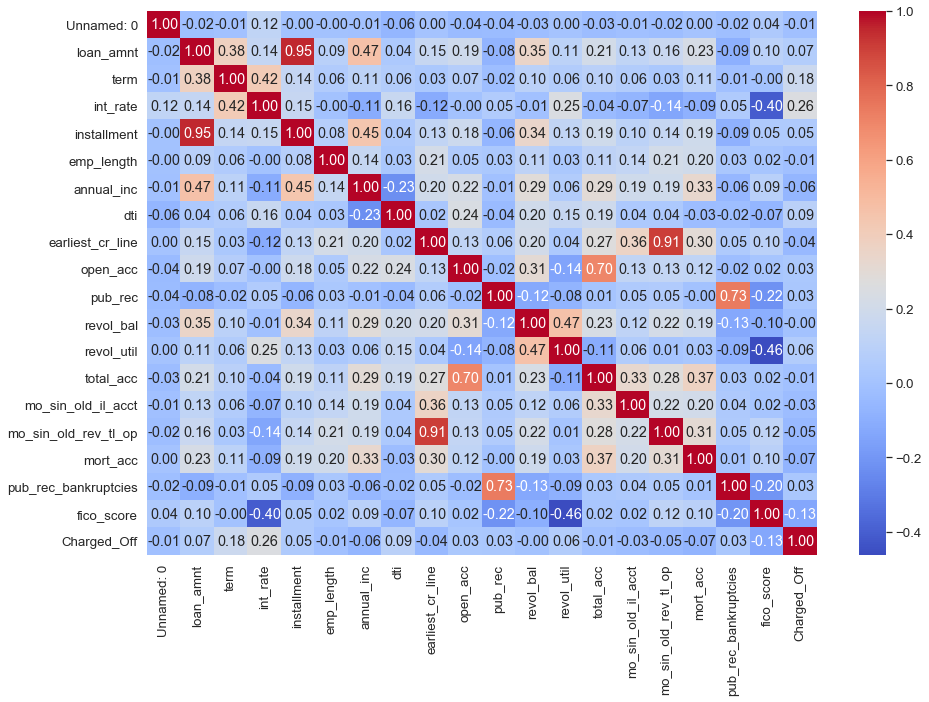

In [160]:
fig, ax = plt.subplots(figsize=(15, 10))  # Sample figsize in inches
cm_df = sns.heatmap(
    df[list_float].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax
)

The linearly correlated features are: 
- "installment" vs "loan_amnt" (0.95)
- "mo_sin_old_rev_tl_op"* vs "earliest_cr_line" (0.91)
- "pub_rec_bankruptcies"* vs "pub_rec" (0.75)
- "total_acc" vs "open_acc" (0.69)   
(*) with null values

Dependence of Charged-off on the predictors: "int_rate" is the most correlated one. (Also see the [Table1](#table1))

In [161]:
cor = df[list_float].corr()
cor.loc[:, :] = np.tril(cor, k=-1)  # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term                  loan_amnt               0.378105
int_rate              Unnamed: 0              0.124569
                      loan_amnt               0.142783
                      term                    0.416423
installment           loan_amnt               0.953467
                      term                    0.139624
                      int_rate                0.154942
annual_inc            loan_amnt               0.465437
                      term                    0.105860
                      int_rate               -0.112058
                      installment             0.445410
                      emp_length              0.144460
dti                   int_rate                0.159620
                      annual_inc             -0.229593
earliest_cr_line      loan_amnt               0.151309
                      int_rate               -0.117172
                      installment             0.132081
                      emp_length              0.213711
          

In [162]:
df[
    [
        "installment",
        "loan_amnt",
        "mo_sin_old_rev_tl_op",
        "earliest_cr_line",
        "total_acc",
        "open_acc",
        "pub_rec_bankruptcies",
        "pub_rec",
    ]
].isnull().any()

installment             False
loan_amnt               False
mo_sin_old_rev_tl_op     True
earliest_cr_line        False
total_acc               False
open_acc                False
pub_rec_bankruptcies     True
pub_rec                 False
dtype: bool

In [163]:
list_linear = [
    "installment",
    "mo_sin_old_rev_tl_op",
    "total_acc",
    "pub_rec_bankruptcies",
]

In [164]:
linear_corr = pd.DataFrame()

In [165]:
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, "pearson_corr"] = df[col].corr(df["Charged_Off"])
linear_corr["abs_pearson_corr"] = abs(linear_corr["pearson_corr"])

Sort the results by the absolute value of the Pearson Correlation

In [166]:
linear_corr.sort_values("abs_pearson_corr", ascending=False, inplace=True)
linear_corr.drop("abs_pearson_corr", axis=1, inplace=True)
linear_corr.drop("Charged_Off", axis=0, inplace=True)

In [167]:
linear_corr.reset_index(inplace=True)
# linear_corr.rename(columns={'index':'variable'}, inplace=True)

Table 1:
<a id="table1"></a>

In [168]:
linear_corr

index  pearson_corr
0               int_rate      0.257634
1                   term      0.176414
2             fico_score     -0.130898
3                    dti      0.093695
4               mort_acc     -0.073438
5              loan_amnt      0.065815
6             annual_inc     -0.063472
7             revol_util      0.061963
8            installment      0.050636
9   mo_sin_old_rev_tl_op     -0.049453
10      earliest_cr_line     -0.044457
11              open_acc      0.033331
12               pub_rec      0.029783
13    mo_sin_old_il_acct     -0.027514
14  pub_rec_bankruptcies      0.027430
15            emp_length     -0.013655
16            Unnamed: 0     -0.010304
17             total_acc     -0.008610
18             revol_bal     -0.002171

The variables most linearly correlated with our target variable are interest rate, loan term, Fico Score and debt-to-income ratio. The least correlated features are the revolving balance, employment length, and public record. 

In [169]:
# Drop the linear correlated features
drop_cols(list_linear)

## 6. Feature Engineering
<a id="featureeng"></a>
I am going to further cleaning the remaining data and get them ready for machine learning.

- One-Hot Encoding
- [Train/Test Split](#split)
- Imputing missing values 
- Scaling 
- [PCA](#pca)
- Linear Dependence of the Charged-Off

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134400 entries, 1 to 226068
Data columns (total 22 columns):
Unnamed: 0             134400 non-null int64
loan_amnt              134400 non-null float64
term                   134400 non-null int64
int_rate               134400 non-null float64
sub_grade              134400 non-null object
emp_length             126501 non-null float64
home_ownership         134400 non-null object
annual_inc             134400 non-null float64
verification_status    134400 non-null object
issue_d                134400 non-null object
purpose                134400 non-null object
dti                    134363 non-null float64
earliest_cr_line       134400 non-null float64
open_acc               134400 non-null float64
pub_rec                134400 non-null float64
revol_bal              134400 non-null float64
revol_util             134313 non-null float64
initial_list_status    134400 non-null object
mo_sin_old_il_acct     124009 non-null float64
mort_a

In [171]:
df.sample(5)

Unnamed: 0  loan_amnt  term  int_rate sub_grade  emp_length  \
157413      207358     7000.0    36     12.29        C1         1.0   
223125      158002    30000.0    36      9.17        B2         0.0   
30203      1345425     4000.0    36     15.61        C4         2.0   
167466      933852     5400.0    36     16.02        C5        10.0   
137518      287491     6600.0    36     17.57        D4         1.0   

       home_ownership  annual_inc verification_status   issue_d  \
157413           RENT    4.903095     Source Verified  Jul-2015   
223125       MORTGAGE    5.338458     Source Verified  Sep-2015   
30203        MORTGAGE    4.681250     Source Verified  Jan-2014   
167466       MORTGAGE    4.835697            Verified  May-2017   
137518           RENT    4.315991     Source Verified  May-2015   

                   purpose    dti  earliest_cr_line  open_acc  pub_rec  \
157413  debt_consolidation  16.80         13.375342      33.0      0.0   
223125  debt_consolidation   7.44         18.378082       6.0      0.0   
30203   debt_consolidation  24.53         19.293151      12.0      0.0   
167466         credit_card  12.77         16.545205      22.0      1.0   
137518         credit_card   4.70         11.539726       6.0      0.0   

        revol_bal  revol_util initial_list_status  mo_sin_old_il_acct  \
157413   4.041630        57.9                   f               105.0   
223125   4.601636        84.8                   w               125.0   
30203    4.242144        92.4                   f               158.0   
167466   2.974051         4.7                   w               165.0   
137518   3.278296        47.4                   f                32.0   

        mort_acc  fico_score  Charged_Off  
157413       0.0       667.0          0.0  
223125       6.0       722.0          0.0  
30203        2.0       682.0          0.0  
167466       4.0       672.0          1.0  
137518       0.0       702.0          1.0

In [172]:
missing_values_table(df)

Your selected dataframe has 22 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values     type
mo_sin_old_il_acct           10391                7.7  float64
emp_length                    7899                5.9  float64
mort_acc                      4666                3.5  float64
revol_util                      87                0.1  float64
dti                             37                0.0  float64

There are 5 variables with missing values (with very small percentage). They are not categorical variables. 

In [173]:
# pandas_profiling.ProfileReport(df)

### 6.1 Categorical Variables
<a id="dummies"></a>

In [174]:
dummy_list = [
    "sub_grade",
    "home_ownership",
    "verification_status",
    "purpose",
    # "addr_state",
    "initial_list_status",
    # "application_type",
]

In [175]:
df[dummy_list].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
initial_list_status    False
dtype: bool

In [176]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [177]:
df.shape

(134400, 70)

In [178]:
df.head(1)

Unnamed: 0  loan_amnt  term  int_rate  emp_length  annual_inc   issue_d  \
1     1264747    20225.0    60     12.99        10.0    4.653222  Jun-2014   

     dti  earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  \
1  19.55         25.383562      12.0      0.0   4.119355        25.4   

   mo_sin_old_il_acct  mort_acc  fico_score  Charged_Off  sub_grade_A2  \
1               104.0       4.0       752.0          0.0             0   

   sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  \
1             0             0             0             0             0   

   sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  sub_grade_C2  \
1             0             0             0             1             0   

   sub_grade_C3  sub_grade_C4  sub_grade_C5  sub_grade_D1  sub_grade_D2  \
1             0             0             0             0             0   

   sub_grade_D3  sub_grade_D4  sub_grade_D5  sub_grade_E1  sub_grade_E2  \
1             0             0             0             0             0   

   sub_grade_E3  sub_grade_E4  sub_grade_E5  sub_grade_F1  sub_grade_F2  \
1             0             0             0             0             0   

   sub_grade_F3  sub_grade_F4  sub_grade_F5  sub_grade_G1  sub_grade_G2  \
1             0             0             0             0             0   

   sub_grade_G3  sub_grade_G4  sub_grade_G5  home_ownership_OTHER  \
1             0             0             0                     0   

   home_ownership_OWN  home_ownership_RENT  \
1                   0                    0   

   verification_status_Source Verified  verification_status_Verified  \
1                                    0                             1   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
1                    0                           1                    0   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
1                         0              0                       0   

   purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  \
1                0               0              0                         0   

   purpose_small_business  purpose_vacation  purpose_wedding  \
1                       0                 0                0   

   initial_list_status_w  
1                      0

Looks good. all data are numerical, except "issue_d", which we will use to split test/train sample and then it will be dropped. 

### 6.2 Train/Test data split
<a id="split"></a>

I will use loans funded on earlier dates to predict the outcome of loans funded on later dates.

In [179]:
# df_2016 = df[df.issue_d.between('2016-01-01', '2016-12-31')]
# df_2016.sample()

In [180]:
df["issue_d"].sample()

184769    Aug-2017
Name: issue_d, dtype: object

In [181]:
df["issue_d"].isnull().any()

False

"issue_d" has month and year, no null values.

In [182]:
df["issue_d"] = pd.to_datetime(df["issue_d"])

In [183]:
df["issue_d"].sample()

84577   2015-10-01
Name: issue_d, dtype: datetime64[ns]

In [184]:
df["issue_d"].describe()

count                  134400
unique                    137
top       2016-03-01 00:00:00
freq                     4832
first     2007-08-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

There are 124 unique values. The first loans were issued in Jan 2007 and the last loans were issued in September 2018. The busiest month was Oct 2014-2015, with ~35000 loans funded in that month. Let's further check the distribution of loans funded per month.

Text(0.5, 1.0, 'Loans funded per Year')

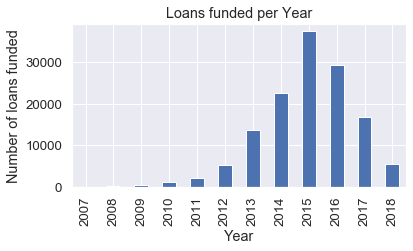

In [185]:
plt.figure(figsize=(6, 3))
df["issue_d"].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel("Year")
plt.ylabel("Number of loans funded")
plt.title("Loans funded per Year")

Interestingly, the funded loans significantly increased since 2013, and continued through 2015.

We will split the train/test sample at 8:2. 

In [186]:
df_train = df.loc[df["issue_d"] < df["issue_d"].quantile(0.8)]
df_test = df.loc[df["issue_d"] >= df["issue_d"].quantile(0.8)]

In [187]:
print("Number of loans in the partition:   ", df_train.shape[0] + df_test.shape[0])
print("Number of loans in the full dataset:", df.shape[0])

Number of loans in the partition:    134400
Number of loans in the full dataset: 134400


Let's look at the summary statistics of the issue dates in the train/test sets.

In [188]:
df_train["issue_d"].describe()

count                  106428
unique                    110
top       2016-03-01 00:00:00
freq                     4832
first     2007-08-01 00:00:00
last      2016-09-01 00:00:00
Name: issue_d, dtype: object

In [189]:
df_test["issue_d"].describe()

count                   27972
unique                     27
top       2016-10-01 00:00:00
freq                     1904
first     2016-10-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Now we can delete the "issue_d"

In [190]:
df_train.drop("issue_d", axis=1, inplace=True)
df_test.drop("issue_d", axis=1, inplace=True)

Now separate the predictor variables from the target variable

In [191]:
X_train = df_train.drop(["Charged_Off"], axis=1).copy()
y_train = df_train.loc[:, "Charged_Off"]

X_test = df_test.drop(["Charged_Off"], axis=1)
y_test = df_test["Charged_Off"]

# X_2016 = df_test[df_test.issue_d.between('2016-01-01', '2016-12-31')].drop(["Charged_Off"], axis=1)
# y_2016 = df_test[df_test.issue_d.between('2016-01-01', '2016-12-31')]["Charged_Off"]

# df[df.issue_d.between('2016-01-01', '2016-12-31')]

In [192]:
X_all = df.drop(["Charged_Off"], axis=1)
Y_all = df.loc[:, "Charged_Off"]

In [193]:
# temp= X_train.drop(X_train._get_numeric_data().columns, axis=1)
# temp.head()

### 6.3 Imputing missing values
<a id="imputing"></a>   
I will create an imputer object with the strategy set to median. I then train this object on the **training** data and use it to fill in the missing values in both the **training and testing** data. This means that missing values in the test data are filled in with the corresponding median value from the training data. We do it this way to avoid the problem of test data leakage.

In [194]:
# missing_values_table(df)

In [195]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy="median")

# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [196]:
missing_values_table(X_train)

Your selected dataframe has 68 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, type]
Index: []

In [197]:
missing_values_table(X_test)

Your selected dataframe has 68 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, type]
Index: []

### 6.4 Feature Scaling
<a id="scaling"></a>  

As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require feature scaling, it's still best practice to take this step when we are comparing multiple algorithms. 


In [198]:
from sklearn.preprocessing import StandardScaler

In [199]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 6.5 PCA visualization of the train data
<a id="pca"></a>  

I'm going to do a PCA analysis to check whether we can find the combinations of variables that explain the most variance. I will use a 2D PCA projection to visualize the entire dataset. I will plot different classes using different colors and check whether the classes are well-separated from each other.

In [200]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train.values)
principalDf = pd.DataFrame(
    data=principalComponents, columns=["principal component 1", "principal component 2"]
)

In [201]:
principalDf.head(5)

principal component 1  principal component 2
0              -1.559422              -0.200521
1               1.541927              -0.321928
2               4.954539               0.056371
3               1.006749               2.194386
4               1.022292              -1.100953

In [202]:
y_train_df = pd.DataFrame(data=y_train.values, columns=["Charged_Off"])

In [203]:
finalDf = pd.concat([principalDf, y_train_df], axis=1)
finalDf.head(5)

principal component 1  principal component 2  Charged_Off
0              -1.559422              -0.200521          0.0
1               1.541927              -0.321928          0.0
2               4.954539               0.056371          0.0
3               1.006749               2.194386          0.0
4               1.022292              -1.100953          1.0

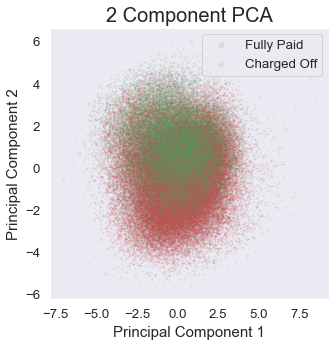

In [204]:
# visualize the PCA
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize=15)
ax.set_ylabel("Principal Component 2", fontsize=15)
ax.set_title("2 Component PCA", fontsize=20)

targets = [0, 1]
colors = ["r", "g"]
for target, color in zip(targets, colors):
    indicesToKeep = finalDf["Charged_Off"] == target
    ax.scatter(
        finalDf.loc[indicesToKeep, "principal component 1"],
        finalDf.loc[indicesToKeep, "principal component 2"],
        c=color,
        s=1,
        alpha=0.1,
    )
ax.legend(["Fully Paid", "Charged Off"], markerscale=5.0)
ax.grid()

In [205]:
pca.explained_variance_ratio_

array([0.0435689 , 0.04252648])

The explained variance tells us how much information (variance) can be attributed to each of the principal components (~ 0.04)

### 6.6 Linear dependence of Charged-Off
<a id="pearson2"></a>  


In [206]:
linear_corr = pd.DataFrame()

In [207]:
# Pearson coefficients
for col in X_train.columns:
    linear_corr.loc[col, "pearson_corr"] = X_train[col].corr(y_train)
linear_corr["abs_pearson_corr"] = abs(linear_corr["pearson_corr"])

Sort the results by the absolute value of the Pearson Correlation

In [208]:
linear_corr.sort_values("abs_pearson_corr", ascending=False, inplace=True)
linear_corr.drop("abs_pearson_corr", axis=1, inplace=True)

In [209]:
linear_corr.reset_index(inplace=True)
# linear_corr.rename(columns={'index':'variable'}, inplace=True)

In [210]:
linear_corr.head(10)

index  pearson_corr
0                        purpose_other     -0.009541
1                     earliest_cr_line      0.008443
2                                 term      0.007859
3                         sub_grade_A4      0.007263
4                  purpose_educational     -0.006915
5                         sub_grade_F2     -0.006729
6                        purpose_house     -0.006676
7                         sub_grade_G5     -0.006343
8  verification_status_Source Verified      0.006032
9                         sub_grade_F1     -0.005899

In [211]:
linear_corr.tail(10)

index  pearson_corr
58              loan_amnt      0.000557
59        purpose_wedding      0.000535
60           sub_grade_E5      0.000475
61           sub_grade_E3      0.000407
62  initial_list_status_w     -0.000344
63       purpose_vacation     -0.000334
64           sub_grade_C2      0.000305
65           sub_grade_C5      0.000270
66     home_ownership_OWN      0.000120
67                    dti      0.000096

In [212]:
df1 = df.copy()

In [213]:
df1[df1.issue_d.between("2016-01-01", "2016-12-31")].sample(10)

Unnamed: 0  loan_amnt  term  int_rate  emp_length  annual_inc  \
217045      748001     5600.0    36     11.99         4.0    4.414990   
202360      662459    15000.0    36     11.47        10.0    4.851264   
181134     2166004    35000.0    60     22.74         5.0    5.033428   
28381       682322    17000.0    60     13.67         4.0    4.826081   
184947     1109657    24000.0    36     10.78        10.0    5.079185   
123216     2198488     9800.0    36     12.74        10.0    4.447174   
844        1082661    14050.0    60     15.77        10.0    4.812920   
147830      663979    12800.0    60      8.59         0.0    5.113947   
150912     2028652     2000.0    36     12.79        10.0    4.778158   
186910     1072663    15000.0    60     23.13        10.0    4.724284   

          issue_d    dti  earliest_cr_line  open_acc  pub_rec  revol_bal  \
217045 2016-04-01  13.11         18.712329       6.0      0.0   3.991890   
202360 2016-06-01  15.38         19.041096       7.0      0.0   3.004321   
181134 2016-12-01  32.76         16.879452      23.0      1.0   4.441884   
28381  2016-06-01  15.99          8.035616      14.0      0.0   4.244054   
184947 2016-01-01   7.24         17.630137       8.0      0.0   4.229451   
123216 2016-12-01  22.89         26.465753      12.0      1.0   4.166489   
844    2016-01-01   6.20         24.550685       5.0      0.0   2.255273   
147830 2016-06-01  15.94         49.147945      11.0      0.0   3.915347   
150912 2016-07-01  21.39         13.375342       8.0      0.0   3.453471   
186910 2016-02-01  35.08         37.139726      13.0      0.0   4.100715   

        revol_util  mo_sin_old_il_acct  mort_acc  fico_score  Charged_Off  \
217045        86.1                54.0       0.0       677.0          1.0   
202360         9.4               183.0       0.0       727.0          0.0   
181134        54.8               164.0       4.0       672.0          1.0   
28381         69.9                38.0       1.0       662.0          1.0   
184947        51.2                18.0       0.0       717.0          0.0   
123216        76.0               160.0       0.0       662.0          0.0   
844            0.3               245.0       4.0       792.0          0.0   
147830        21.4               162.0       0.0       722.0          0.0   
150912        20.4                63.0       0.0       662.0          1.0   
186910        40.8               132.0       0.0       682.0          0.0   

        sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  \
217045             0             0             0             0             0   
202360             0             0             0             0             0   
181134             0             0             0             0             0   
28381              0             0             0             0             0   
184947             0             0             0             0             0   
123216             0             0             0             0             0   
844                0             0             0             0             0   
147830             0             0             0             1             0   
150912             0             0             0             0             0   
186910             0             0             0             0             0   

        sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  \
217045             0             0             0             0             1   
202360             0             0             0             1             0   
181134             0             0             0             0             0   
28381              0             0             0             0             0   
184947             0             0             1             0             0   
123216             0             0             0             0             1   
844                0             0             0             0             0  

This is not as informative as the correlation analysis done earlier, due to the one hot encoding of the categorical features. However, we still get the information that probably the state feature is not that important 

## 7. Modeling 
<a id="modeling"></a>

- I will implement the ML pipeline with Dimension reduction and the chosen model
- The following models are evaluated, with stratified Kfold cross validation procedure* and grid search. 
    - Logistic regression with SGD training
    - Random Forest
    - KNN
    - Gradient Boosting
- Metrics: AUROC, confusion matrix

As we have an unbalanced dataset problem and we care accuracy of one class over other(false-positives (loans that are fully paid but are predicted to be charged off) are not so bad definitely do not want any false negatives (predicted to be fully paid but eventually charged off)), we could display the class accuracies in confusion matrices.

*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).


In [214]:
# CV model with Kfold stratified cross val
kfold = 7
random_state = 42

### 7.1 Logistic Regression with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
<a id="logreg"></a>
logistic regression with stochastic gradient descent training.

In [215]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [216]:
pipeline_sgdlr = Pipeline(
    [
        (
            "model",
            SGDClassifier(
                loss="log",
                max_iter=1000,
                tol=1e-3,
                random_state=random_state,
                warm_start=False,
            ),
        )
    ]
)

A small grid of hyper parameters to search over called [GridSearchCV](https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998). Here we use [L1, L2](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) Regularization!

In [217]:
param_grid_sgdlr = {
    "model__alpha": [10 ** -5, 10 ** -1, 10 ** 2],
    "model__penalty": ["l1", "l2"],
}

In [218]:
grid_sgdlr = GridSearchCV(
    estimator=pipeline_sgdlr,
    param_grid=param_grid_sgdlr,
    scoring="roc_auc",
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

Grid search and train the final model on the whole dataset

In [219]:
grid_sgdlr.fit(X_train, y_train)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   16.3s finished


GridSearchCV(cv=7, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                                                      loss='log', max_iter=1000,
                                                      n_iter_no_change=5,
                                                      n_jobs=None, penalty='l2',
                                                 

Mean cross-validated AUROC score of the best model

In [220]:
# pd.DataFrame(grid_sgdlr.cv_results_)

In [221]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print("Best score: ", grid_sgdlr.best_score_)
print("Best parameters set: \n", grid_sgdlr.best_params_)

Best score:  0.7130577962238516
Best parameters set: 
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


In [222]:
y_pred_sgdlr = sgdlr_estimator.predict(X_test)
y_prob_sgdlr = sgdlr_estimator.predict_proba(X_test)[:, 1]

In [223]:
y_train_pred_sgdlr = sgdlr_estimator.predict(X_train)
y_train_prob_sgdlr = sgdlr_estimator.predict_proba(X_train)[:, 1]

**Feature Coefficients in the Logistic Regress Model**

In [224]:
LRmodel_l2 = SGDClassifier(
    loss="log",
    max_iter=1000,
    tol=1e-3,
    random_state=random_state,
    warm_start=False,
    alpha=0.1,
    penalty="l2",
)

In [225]:
LRmodel_l2.fit(X_train, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [226]:
temp = sorted(
    zip(np.round(LRmodel_l2.coef_.reshape(-1), 3), X_train.columns.values),
    key=lambda x: -abs(x[0]),
)
weight = [x for x, _ in temp]
feature = [x for _, x in temp]

In [227]:
print("Logistic Regression (L2) Coefficients: Top 10")
pd.DataFrame({"weight": weight}, index=feature).head(10)

Logistic Regression (L2) Coefficients: Top 10


weight
int_rate              0.187
term                  0.175
fico_score           -0.111
dti                   0.100
annual_inc           -0.073
home_ownership_RENT   0.063
mort_acc             -0.061
loan_amnt             0.058
open_acc              0.056
sub_grade_A3         -0.054

From previous Pearson Correlation analysis, the top 6 are: int_rate (0.25), term, fico_score, dti, mort_acc, annul_inc.

**Recursive Feature Elimination ([RFE](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html))**

In [228]:
from sklearn.feature_selection import RFE

rfe_l2 = RFE(
    LRmodel_l2, n_features_to_select=1
)  # If None, half of the features are selected.
rfe_l2.fit(X_train, y_train)

RFE(estimator=SGDClassifier(alpha=0.1, average=False, class_weight=None,
                            early_stopping=False, epsilon=0.1, eta0=0.0,
                            fit_intercept=True, l1_ratio=0.15,
                            learning_rate='optimal', loss='log', max_iter=1000,
                            n_iter_no_change=5, n_jobs=None, penalty='l2',
                            power_t=0.5, random_state=42, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [229]:
temp = sorted(zip(map(lambda x: round(x, 4), rfe_l2.ranking_), X_train.columns))
rank = [x for x, _ in temp]
feature = [x for _, x in temp]
print("Logistic Regression (L2) RFE Result: Top 10")
pd.DataFrame({"rank": rank}, index=feature).head(10)

Logistic Regression (L2) RFE Result: Top 10


rank
int_rate                1
term                    2
fico_score              3
dti                     4
mort_acc                5
annual_inc              6
loan_amnt               7
home_ownership_RENT     8
Unnamed: 0              9
sub_grade_A4           10

Feature coefficients tell us that the top 5 features and their weights in the fitting are:
Term (0.18), int_rate(0.156), dti(0.125), fico_score(-0.113), annual_inc(-0.093)
while, another way to look at the features, RFE, tells us the top 5 features are:
int_rate, term, dti, fico_score, mort_acc.
These two methods have slightly different ranks on annual_inc & mort_acct; int_rate & term

### 7.2 Random Forest
<a id="rf"></a>

In [230]:
from sklearn.ensemble import RandomForestClassifier

In [231]:
rf = RandomForestClassifier(
    n_jobs=-1, n_estimators=500, random_state=random_state, max_features="sqrt"
)
param_grid_rf = {
    #'n_estimators': [50, 100],
    "class_weight": [
        {0: 1, 1: 1}
    ],  #'model__class_weight': [{0:1, 1:1}, {0:1,1:2}, {0:1, 1:3}, {0:1, 1:4}]
    #'model__min_samples_split':[2,3]
    #'model__max_features':[2,3,4,5],
    # "model__max_depth":range(8,13)
}

In [232]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

In [233]:
grid_rf.fit(X_train, y_train)

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.0min finished


GridSearchCV(cv=7, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [234]:
rf_estimator = grid_rf.best_estimator_
print("Best score: ", grid_rf.best_score_)
print("Best parameters set: \n", grid_rf.best_params_)

Best score:  0.7141054659261314
Best parameters set: 
 {'class_weight': {0: 1, 1: 1}}


In [235]:
y_pred_rf = rf_estimator.predict(X_test)
y_prob_rf = rf_estimator.predict_proba(X_test)[:, 1]

In [236]:
y_train_pred_rf = rf_estimator.predict(X_train)
y_train_prob_rf = rf_estimator.predict_proba(X_train)[:, 1]

Not as good as SDG Logistic regression. 
Let's check the feature importance. 

#### Feature importance

In [237]:
names = list(X_train)

In [238]:
# print(sorted(zip(map(lambda x: round(x, 4), grid_rf.best_estimator_.feature_importances_), names), reverse=True))

In [239]:
# from tabulate import tabulate
# headers = ["name", "score"]
# values = sorted(zip(X_train.columns, grid_rf.best_estimator_.feature_importances_), key=lambda x:x[1] * -1)
# print(tabulate(values, headers, tablefmt="plain"))

In [240]:
feature_importances = pd.DataFrame(
    grid_rf.best_estimator_.feature_importances_,
    index=X_train.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)

In [241]:
print("Features sorted by their score: Top 10")
feature_importances.head(10)

Features sorted by their score: Top 10


importance
int_rate              0.081077
dti                   0.076834
Unnamed: 0            0.076677
revol_bal             0.070911
revol_util            0.069771
earliest_cr_line      0.069495
annual_inc            0.067393
mo_sin_old_il_acct    0.066531
loan_amnt             0.061838
open_acc              0.052832

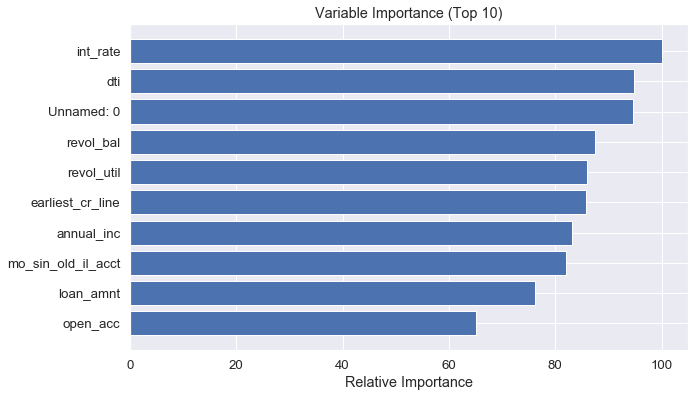

In [242]:
# Normalize The Features and visulize the top 10 features
%matplotlib inline
feature_importance = 100.0 * (
    grid_rf.best_estimator_.feature_importances_
    / grid_rf.best_estimator_.feature_importances_.max()
)
sorted_idx = sorted(
    range(len(feature_importance)), key=lambda i: feature_importance[i]
)[-10:]
pos = np.arange(len(sorted_idx)) + 0.5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance (Top 10)")
plt.show()

In [243]:
print("Features sorted by their score: Bottom 10")
feature_importances.tail(10)

Features sorted by their score: Bottom 10


importance
sub_grade_F5                0.000789
sub_grade_G1                0.000607
sub_grade_G2                0.000426
sub_grade_G3                0.000395
purpose_wedding             0.000340
purpose_renewable_energy    0.000291
sub_grade_G5                0.000189
purpose_educational         0.000170
sub_grade_G4                0.000162
home_ownership_OTHER        0.000063

#### Visualizing a Single Decision Tree

In [244]:
grid_rf.best_estimator_[1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1273642419, splitter='best')

In [245]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

rf_big = RandomForestClassifier(
    n_jobs=-1, random_state=random_state, n_estimators=10, max_depth=6
)
rf_big.fit(X_train, y_train)

# Pull out one tree from the forest
tree_big = rf_big.estimators_[5]
# Export the image to a dot file
export_graphviz(
    tree_big,
    out_file="./data/big_tree.dot",
    feature_names=names,
    rounded=True,
    precision=1,
)
# Use dot file to create a graph
(graph,) = pydot.graph_from_dot_file("./data/big_tree.dot")
# Write graph to a png file
graph.write_png("big_tree.png")

<img src="big_tree.png">

In [246]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(
    n_jobs=-1, random_state=random_state, n_estimators=10, max_depth=3
)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(
    tree_small,
    out_file="./data/small_tree.dot",
    feature_names=names,
    rounded=True,
    precision=1,
)
(graph,) = pydot.graph_from_dot_file("./data/small_tree.dot")
graph.write_png("small_tree.png")

In [247]:
# <img src="small_tree.png">

### 7.3 KNN 
<a id="knn"></a>

I need to reduce the number of the features for KNN (<10) for better performance. This is what normally suggested for KNN to have less than 10 features.

I use LDA for dimension reduction 

In [248]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

In [249]:
# chaining a PCA and a knn
pipeline_knn = Pipeline(
    [("pca", decomposition.PCA()), ("model", KNeighborsClassifier(n_jobs=-1))]
)

pipeline_knn2 = Pipeline(
    [("lda", LinearDiscriminantAnalysis()), ("model", KNeighborsClassifier(n_jobs=-1))]
)

In [250]:
param_grid_knn = {"pca__n_components": range(3, 6), "model__n_neighbors": [5, 25, 125]}
param_grid_knn2 = {"lda__n_components": range(3, 6), "model__n_neighbors": [5, 25, 125]}

In [251]:
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)
grid_knn2 = GridSearchCV(
    estimator=pipeline_knn2,
    param_grid=param_grid_knn2,
    scoring="roc_auc",
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
    cv=kfold,
    verbose=1,
    return_train_score=False,
)

In [252]:
# %%time
# grid_knn.fit(X_train, y_train) # very slow

In [253]:
%%time
grid_knn2.fit(X_train, y_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   36.2s finished


CPU times: user 5.81 s, sys: 1.54 s, total: 7.35 s
Wall time: 37.6 s


GridSearchCV(cv=7, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lda',
                                        LinearDiscriminantAnalysis(n_components=None,
                                                                   priors=None,
                                                                   shrinkage=None,
                                                                   solver='svd',
                                                                   store_covariance=False,
                                                                   tol=0.0001)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
     

In [254]:
knn_estimator2 = grid_knn2.best_estimator_
print("Best score: ", grid_knn2.best_score_)
print("Best parameters set: \n", grid_knn2.best_params_)

Best score:  0.7051224345261259
Best parameters set: 
 {'lda__n_components': 3, 'model__n_neighbors': 125}


Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression. 

In [255]:
y_pred_knn = knn_estimator2.predict(X_test)
y_prob_knn = knn_estimator2.predict_proba(X_test)[:, 1]

In [256]:
y_train_pred_knn = knn_estimator2.predict(X_train)
y_train_prob_knn = knn_estimator2.predict_proba(X_train)[:, 1]

### 7.4 Gradient Boosting Classifier

In [257]:
def run_models(X_train, y_train, X_test, y_test, model_type="Non-balanced"):

    param_test1 = {"n_estimators": range(20, 81, 10)}
    clf = GridSearchCV(
        estimator=GradientBoostingClassifier(
            learning_rate=0.1,
            min_samples_split=500,
            min_samples_leaf=50,
            max_depth=8,
            max_features="sqrt",
            subsample=0.8,
            random_state=10,
        ),
        param_grid=param_test1,
        scoring="roc_auc",
        n_jobs=4,
        iid=False,
        cv=5,
    )

    cols = [
        "model",
        "matthews_corrcoef",
        "roc_auc_score",
        "precision_score",
        "recall_score",
        "f1_score",
    ]

    models_report = pd.DataFrame(columns=cols)
    conf_matrix = dict()

    #     for clf, clf_name in zip(param_test1.values(), param_test1.keys()):

    clf.fit(X_train, y_train)
    clf_name = GradientBoostingClassifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    print("computing {} - {} ".format(clf_name, model_type))

    tmp = pd.Series(
        {
            "model_type": model_type,
            "model": clf_name,
            "roc_auc_score": metrics.roc_auc_score(y_test, y_score),
            "matthews_corrcoef": metrics.matthews_corrcoef(y_test, y_pred),
            "precision_score": metrics.precision_score(y_test, y_pred),
            "recall_score": metrics.recall_score(y_test, y_pred),
            "f1_score": metrics.f1_score(y_test, y_pred),
        }
    )

    models_report = models_report.append(tmp, ignore_index=True)
    conf_matrix[clf_name] = pd.crosstab(
        y_test, y_pred, rownames=["True"], colnames=["Predicted"], margins=False
    )
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, y_score, drop_intermediate=False, pos_label=1
    )

    plt.figure(1, figsize=(6, 6))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC curve - {}".format(model_type))
    plt.plot(fpr, tpr, label=clf_name)
    plt.legend(loc=2, prop={"size": 11})
    plt.plot([0, 1], [0, 1], color="black")

    return models_report, conf_matrix, clf

computing <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> - Non-balanced 


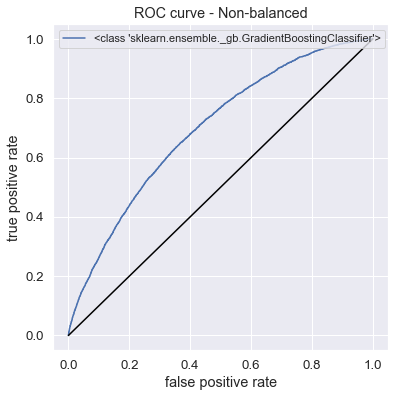

In [258]:
# mpl.rc("savefig", dpi=300)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, target.values, test_size=0.4, random_state=0)
models_report, conf_matrix, grid_gb = run_models(
    X_train, y_train, X_test, y_test, model_type="Non-balanced"
)

In [259]:
models_report

model  matthews_corrcoef  \
0  <class 'sklearn.ensemble._gb.GradientBoostingC...           0.165194   

   roc_auc_score  precision_score  recall_score  f1_score    model_type  
0       0.694603         0.496757      0.127053  0.202351  Non-balanced

In [260]:
conf_matrix

{sklearn.ensemble._gb.GradientBoostingClassifier: Predicted    0.0  1.0
 True                 
 0.0        21167  776
 1.0         5263  766}

In [261]:
grid_gb

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [262]:
gb_estimator = grid_gb.best_estimator_
print("Best score: ", grid_gb.best_score_)
print("Best parameters set: \n", grid_gb.best_params_)

Best score:  0.7207414614220283
Best parameters set: 
 {'n_estimators': 80}


In [263]:
y_pred_gb = gb_estimator.predict(X_test)
y_prob_gb = gb_estimator.predict_proba(X_test)[:, 1]

In [264]:
y_train_pred_gb = gb_estimator.predict(X_train)
y_train_prob_gb = gb_estimator.predict_proba(X_train)[:, 1]

### 7.5 Model Comparison & Evaluation 
<a id="evaluate"></a>

AUROC                Algorithm
0  0.713058  SGD Logistic Regression
1  0.714105             RandomForest
2  0.705122              KNeighboors
3  0.720741         GradientBoosting

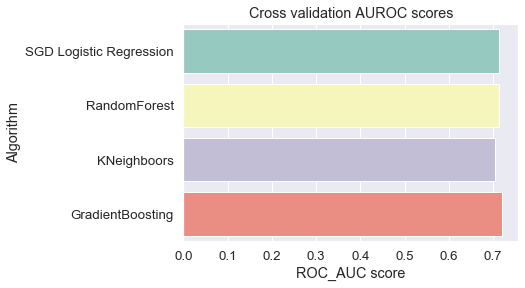

In [265]:
# plot the AUROC scores on the training dataset.
auroc_means = [
    grid_sgdlr.best_score_,
    grid_rf.best_score_,
    grid_knn2.best_score_,
    grid_gb.best_score_,
]
auroc_res = pd.DataFrame(
    {
        "AUROC": auroc_means,
        "Algorithm": [
            "SGD Logistic Regression",
            "RandomForest",
            "KNeighboors",
            "GradientBoosting",
        ],
    }
)

g = sns.barplot("AUROC", "Algorithm", data=auroc_res, palette="Set3", orient="h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")
auroc_res

I write 2 functions. One for summary of the performance of the model (on both training and testing data), the other one for plotting the ROC for the testing data. 

In [266]:
def evaluation(
    X_train, X_test, Y_train, Y_test, Y_train_pred, Y_train_prob, Y_pred, Y_prob
):
    print("--- ROC AUC ---")
    print("Training Set:", roc_auc_score(Y_train, Y_train_prob))
    print("Test Set:", roc_auc_score(Y_test, Y_prob))

    print("\n--- Accuracy ---")
    print("Training Set:", accuracy_score(Y_train, Y_train_pred))
    print("Test Set:", accuracy_score(Y_test, Y_pred))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    print("\n--- Confusion Matrix ---")
    print("True Positive:", tp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    print("False Positive:", fp)

    print("\n--- Precision ---")
    print("Training Set:", precision_score(Y_train, Y_train_pred))
    print("Test Set:", precision_score(Y_test, Y_pred))

    print("\n--- Recall ---")
    print("Training Set:", recall_score(Y_train, Y_train_pred))
    print("Test Set:", recall_score(Y_test, Y_pred))

    print("\n--- F1 Score ---")
    print("Training Set:", f1_score(Y_train, Y_train_pred))
    print("Test Set:", f1_score(Y_test, Y_pred))


def plot_ROC(X_test, Y_test, Y_prob):

    # Y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(Y_test, Y_prob, pos_label=1)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    # These are the points at threshold = 0.1~0.5
    x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)]
    x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

    fig = plt.figure()
    plt.plot(fpr, tpr, color="r", lw=2)
    plt.plot([0, 1], [0, 1], color="b", lw=2, linestyle="--")
    plt.plot(x1, x2, color="k", lw=3, label="threshold = 0.1 ~ 0.5")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Area = {:.2f})".format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()

===== Logistic Regression =====
--- ROC AUC ---
Training Set: 0.713893524187887
Test Set: 0.6924287702179746

--- Accuracy ---
Training Set: 0.8087439395647762
Test Set: 0.7845345345345346

--- Confusion Matrix ---
True Positive: 209
False Negative: 5820
True Negative: 21736
False Positive: 207

--- Precision ---
Training Set: 0.6466942148760331
Test Set: 0.5024038461538461

--- Recall ---
Training Set: 0.015270527394252817
Test Set: 0.03466578205340853

--- F1 Score ---
Training Set: 0.029836518755064108
Test Set: 0.06485647788983707


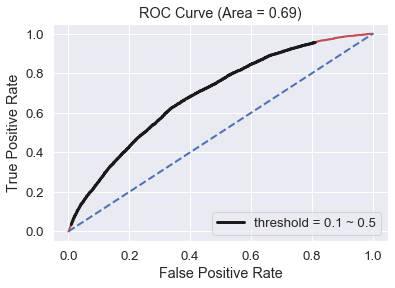

In [267]:
print("===== Logistic Regression =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_sgdlr,
    y_train_prob_sgdlr,
    y_pred_sgdlr,
    y_prob_sgdlr,
)
plot_ROC(X_test, y_test, y_prob_sgdlr)

===== KNN =====
--- ROC AUC ---
Training Set: 0.7222399232944106
Test Set: 0.684897042501748

--- Accuracy ---
Training Set: 0.8105385800729131
Test Set: 0.784963534963535

--- Confusion Matrix ---
True Positive: 342
False Negative: 5687
True Negative: 21615
False Positive: 328

--- Precision ---
Training Set: 0.5583187390542907
Test Set: 0.5104477611940299

--- Recall ---
Training Set: 0.07776747816753671
Test Set: 0.05672582517830486

--- F1 Score ---
Training Set: 0.13651935594381637
Test Set: 0.10210479175996418


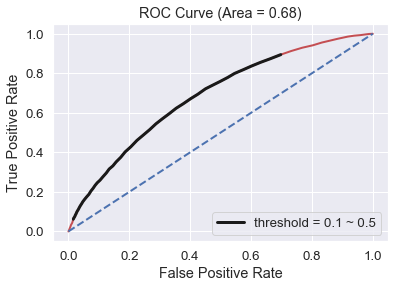

In [268]:
print("===== KNN =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_knn,
    y_train_prob_knn,
    y_pred_knn,
    y_prob_knn,
)
plot_ROC(X_test, y_test, y_prob_knn)

===== Random Forest =====
--- ROC AUC ---
Training Set: 1.0
Test Set: 0.6831611104290041

--- Accuracy ---
Training Set: 1.0
Test Set: 0.7860717860717861

--- Confusion Matrix ---
True Positive: 452
False Negative: 5577
True Negative: 21536
False Positive: 407

--- Precision ---
Training Set: 1.0
Test Set: 0.5261932479627474

--- Recall ---
Training Set: 1.0
Test Set: 0.07497097362746724

--- F1 Score ---
Training Set: 1.0
Test Set: 0.13124274099883856


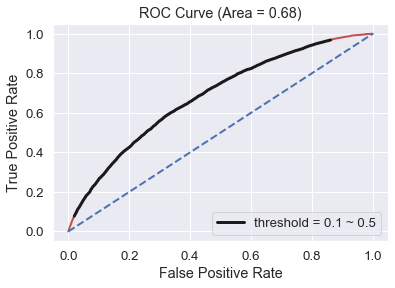

In [269]:
print("===== Random Forest =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_rf,
    y_train_prob_rf,
    y_pred_rf,
    y_prob_rf,
)
plot_ROC(X_test, y_test, y_prob_rf)

===== Gradient Boosting =====
--- ROC AUC ---
Training Set: 0.7579789596757873
Test Set: 0.6946033302541643

--- Accuracy ---
Training Set: 0.8177547261998722
Test Set: 0.7841055341055341

--- Confusion Matrix ---
True Positive: 766
False Negative: 5263
True Negative: 21167
False Positive: 776

--- Precision ---
Training Set: 0.6602620087336245
Test Set: 0.496757457846952

--- Recall ---
Training Set: 0.11065033907401083
Test Set: 0.12705257920053076

--- F1 Score ---
Training Set: 0.18953702156108976
Test Set: 0.2023510764760269


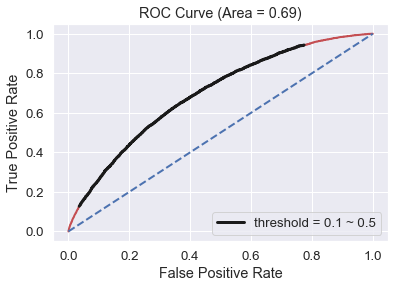

In [270]:
print("===== Gradient Boosting =====")
evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    y_train_pred_gb,
    y_train_prob_gb,
    y_pred_gb,
    y_prob_gb,
)
plot_ROC(X_test, y_test, y_prob_gb)

Gradient Boosting performs slighter better than others, but Logistic Regress runs much faster.

In order to compare the profitability of my model and the profitability the bank actually made (for the test set), I assume:

- If the loan is granted and the it doesn't get repaid, we lose 1
- If the loan is granted and the it does get repaid, we gain 1
- We gain 0 if the loan is not granted

In [271]:
# bank
score_bank = sum(y_test == 0) - sum(y_test == 1)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(y_test, grid_sgdlr.predict(X_test)).ravel()
score_lr = tn - fn

print("The bank scores {} points".format(score_bank))
print("The Logistic regression model scores {} points".format(score_lr))

The bank scores 15914 points
The Logistic regression model scores 15916 points


In [272]:
# bank
score_bank = sum(y_test == 0) - sum(y_test == 1)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(y_test, grid_gb.predict(X_test)).ravel()
score_gb = tn - fn

print("The bank scores {} points".format(score_bank))
print("The Logistic regression model scores {} points".format(score_gb))

The bank scores 15914 points
The Logistic regression model scores 15904 points


There is some  moore improvement. But, here it's not a fair comparison because I am using existing data of borrowers to train my model while the bank didn't have these data to begin with.

# Now, what happens if we use CHEAT data features to predict the Charged-Off!

In [273]:
loan = pd.read_csv("./data/01accepted_2007_to_2018Q4.csv")

In [274]:
# loan_copy = loan.copy()
# loan = loan_copy.copy()

In [275]:
# determine nan percentage
check_null = loan.isnull().sum().sort_values(ascending=False) / len(loan)

# print all with 20% NaNs
print(check_null[check_null > 0.2])

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996037
payment_plan_start_date                       0.995081
hardship_end_date                             0.995081
hardship_type                                 0.995081
hardship_reason                               0.995081
hardship_status                               0.995081
deferral_term                                 0.995081
hardship_amount                               0.995081
hardship_last_payment_amount                  0.995081
hardship_payoff_balance_amount                0.995081
hardship_loan_status                          0.995081
hardship_dpd                                  0.995081
hardship_length                               0.995081
hardship_start_date                           0.995081
settlement_term                               0.984704
settlement_percentage                         0.984704
debt_settlement_flag_date                     0.984704
settlement

In [276]:
# loads of columns ... so let's remove these
loan.drop(check_null[check_null > 0.2].index, axis=1, inplace=True)
# loan.dropna(axis=0, thresh=30,inplace=True)
# loan.a.value_counts

After culling the NaN dominated columns, there are still a lot of features. Some will have useful info, others not. At this point based on the previous EDA I carefully weeded out any column that I think may be well useless. My main criteria is whether a feature is dominated by a single value (> 80%)
1. id and member_id: somehow I don't think these will be useful, condidering all were unique
2. Policy_cose: this is the same for all customers
3. url: this is the webpage of the loan data. May come in handy at someother stage (maybe)
4. zip_code and addr_state: I really don't think that the state and location of aperson will determine if they will repay a loan. Although, I could be wrong ....
5. application_type: was >99% INDIVIDUAL
6. 'pymnt_plan': 99.99% N
7. emp_title: this could be useful. Possbly through NLP. 
8. acc_now_delinq: > 99% 0
9. title: may be very useful. Requires NLP
10. collections_12_mths_ex_med: ~98% 0
11. collection_recovery_fee > 98% 0 

In [277]:
del_cols = [
    "id",
    "policy_code",
    "url",
    "zip_code",
    "addr_state",
    "pymnt_plan",
    "emp_title",
    "application_type",
    "acc_now_delinq",
    "title",
    "collections_12_mths_ex_med",
    "collection_recovery_fee",
]

In [278]:
loan = loan.drop(del_cols, axis=1)

The point of this exercise is to predict if a loan will be "Charged Off". Let's see the breakdown of the target column: 'loan_status'

Yikes! Ok for now we will ignore "Current" customers. Note, we could use the model generated to predict whether a "Current" customers will be "Charged Off". 

In [279]:
loan = loan[loan["loan_status"] != "Current"]

The column 'emp_length' may be useful

Let's convert this to categorical data

In [280]:
# remove all rows with nans
loan.dropna(axis=0, how="any", inplace=True)

In [281]:
print(loan["loan_status"].value_counts() / len(loan))

Fully Paid            0.781954
Charged Off           0.192160
Late (31-120 days)    0.016169
In Grace Period       0.006384
Late (16-30 days)     0.003284
Default               0.000049
Name: loan_status, dtype: float64


In [282]:
loan.shape

(102914, 82)

In [283]:
# loan.to_csv("./data/loan_81_features.csv")

In [284]:
loan = loan.sample(frac=0.01)
loan.shape

(1029, 82)

In [285]:
# extract the target column and convert to Charged Off to 1 and the rest as 0
mask = loan.loan_status == "Charged Off"
loan["target"] = 0
loan.loc[mask, "target"] = 1

target = loan["target"]

loan = loan.drop(["loan_status", "target"], axis=1)

In [286]:
target.value_counts()

0    816
1    213
Name: target, dtype: int64

The next step is to convert all categorical data to dummy numerical data. First let's seperate the categorical from number columns

In [287]:
loan_categorical = loan.select_dtypes(include=["object"], exclude=["float64", "int64"])
features = loan.select_dtypes(include=["float64", "int64"])

In [288]:
# one-hot-encode the categorical variables and combine with the numercal values
for col in list(loan_categorical):
    dummy = pd.get_dummies(loan_categorical[col])
    features = pd.concat([features, dummy], axis=1)

In [289]:
# time to split and build models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)

The model we will build is Random Forest

In [290]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [291]:
RF = RandomForestClassifier(n_estimators=500, n_jobs=-1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("Test score: {:.2f}".format(RF.score(X_test, y_test)))
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_pred))
print(
    "Classification report for Random Forest classifier %s:\n%s\n"
    % (RF, classification_report(y_test, y_pred))
)

Test score: 0.96
Confusion matrix:
[[205   0]
 [ 10  43]]
Classification report for Random Forest classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       205
           1       1.00      0.81      0.90        53

    accuracy                           0.96       258
   macro avg       0.98      0.91      0.94       258
weighted avg       0.96      0.96      0.96       258




Nice! Carefully selecting features as well as some feature engineering paid off! `100% precision and 98% Recall` for all "Charged off" loans! Since the dataset is skewed, let's have a llok at the Precision and Recall curve

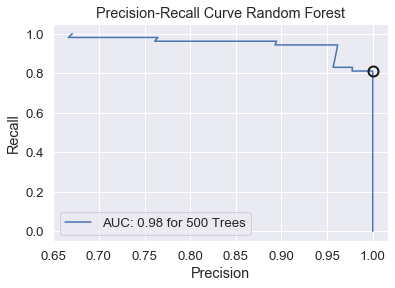

In [292]:
precision, recall, thresholds = precision_recall_curve(
    y_test, RF.predict_proba(X_test)[:, 1]
)
AUC = average_precision_score(y_test, RF.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="AUC: {:.2f} for {} Trees".format(AUC, 500))
close_default_rf = np.argmin(np.abs(thresholds - 0.5))
plt.plot(
    precision[close_default_rf],
    recall[close_default_rf],
    "o",
    c="k",
    markersize=10,
    fillstyle="none",
    mew=2,
)

plt.ylabel("Recall")
plt.xlabel("Precision")
plt.title("Precision-Recall Curve Random Forest")
plt.legend(loc="best")
plt.show()

Next: The next step? We can use this model to determine the probability any of the "Current" customers will be "Charged Off". 

### 8. Conclusion
<a id="conclusion"></a>

I applied ML to predict the probability that a requested loan on LendingCLub will be charged off. After training with 4 models (Logistic Regression, random forest, KNN, and Gradient Boosting), I found that the `Gradient Boosting classifier` performs the best (highest AUROC score of ~0.2) and the score on the testing dataset is slightly lower at --. 

Surprisingly when the `cheating data` have not been removed, we got a very high accuracy and F1 score (~.99). it seems this data makes our model completely bias and easily the Charged-off status can be predicted!

According to the Pearson correlation between the features and the target variable, the most important features for prediction Charged-off are interest rate, term, debt-to-income ratio, and FICO score.

In [293]:
# TBD

<!-- 
# Plot learning curves
#grid_sgdlr, grid_rf,grid_knn

    def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

    g = plot_learning_curve(grid_sgdlr.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)
    g = plot_learning_curve(grid_rf.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=kfold)
    g = plot_learning_curve(grid_knn2.best_estimator_,"KNN learning curves",X_train,y_train,cv=kfold) 
    -->

<!--
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print('========='+classifier+'=========')
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))
def draw_confusion_matrices(confusion_matricies):
    #class_names = ['Not','Churn']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        cal_evaluation(classifier, cm, auc)
        """ 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title('Confusion Matrix for {}'.format(classifier)) 
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        ax.xaxis.set_ticklabels(['0', '1'])
        ax.yaxis.set_ticklabels(['0', '1'])
-->
